Project aim - To chracterise the variations in oscialltions during the flare and see how this compares to the energy released by the flare

In [75]:
import numpy as np
from numpy.fft import rfft, rfftfreq


from scipy import signal
from scipy.fft import fft, fftshift
from scipy.special._ufuncs import gammainc, gamma
from scipy.optimize import fminbound
from scipy.optimize import curve_fit

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import ImageNormalize, SqrtStretch
from astropy.io import fits
from astropy.visualization.mpl_normalize import AsymmetricPercentileInterval
from astropy.visualization import astropy_mpl_style


import sunpy.coordinates  # NOQA
import sunpy.map
import sunpy.data.sample
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.visualization.animator import MapSequenceAnimator
from sunpy.map import Map
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.coordinates import Helioprojective, get_body_heliographic_stonyhurst
from sunpy.time import parse_time

import datetime


from wavelet_function import wavelet

import pywt


import aiapy.data.sample as sample_data
from aiapy.calibrate import register, update_pointing



from PIL import Image

In [4]:
def Fits_to_maps(file):
    """
    file - string to location of wanted files
    """
    # Creating path to images of specified wavelength
    path = os.listdir(file)
    
    # Creating empty array to append processed maps
    maps = []

    # Looping over each image file in the directory and turning them into maps
    for img in path:
        img_path = os.path.join(file, img)
        
        # Loading the FITS file as a SunPy map
        aia_map = sunpy.map.Map(img_path)
        
        # # Check if aia_map is a list (indicating multiple HDUs) and select the first one
        # if isinstance(aia_map, list):
        #     aia_map = aia_map[0]  # Select the primary HDU if only one is needed
        
        maps.append(aia_map)
    
    return maps

In [5]:
def intenisty_sum(maps):


    intensity = []
 # summing intenisty of every pixel in the images 
    for map in maps:
        intensity_sum = map.data.sum()
        intensity.append(intensity_sum)
    return intensity

In [354]:
#loading in all my data

maps_1700 = Fits_to_maps('AIA_1700_prep_rot_done')
maps_1700 = sorted(maps_1700,key = lambda m:m.date)


maps_171 = Fits_to_maps('AIA_171_prep_rot_done')
maps_171 = sorted(maps_171,key = lambda m:m.date)


maps_94 = Fits_to_maps('AIA_94_prep_rot_done')
maps_94 = sorted(maps_94,key = lambda m:m.date)


maps_304 = Fits_to_maps('AIA_304_prep_rot_done')
maps_304 = sorted(maps_304,key = lambda m:m.date)


# Trying to plot a red rectangle over my region of interest

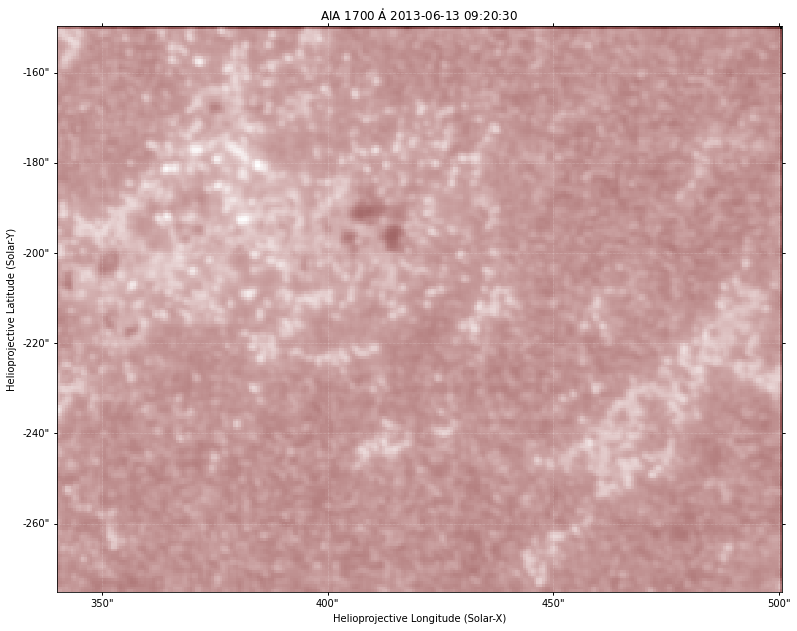

In [ ]:
# bottom_left = SkyCoord((415.5)* u.arcsec, -197.5 * u.arcsec, frame=maps_1700[0].coordinate_frame)
# top_right = SkyCoord((416.5) * u.arcsec, -196 * u.arcsec, frame=maps_1700[0].coordinate_frame)   

x_start, x_end = 415.5*u.arcsec, 416.5*u.arcsec
y_start, y_end = -197.5*u.arcsec, -196*u.arcsec

width = 50*u.arcsec
height = 50*u.arcsec

bottom_left = SkyCoord(415.5 * u.arcsec, -197.5 * u.arcsec, frame=maps_1700[0].coordinate_frame)

# Convert the bottom-left corner to pixel coordinates
bottom_left_pixel = maps_1700[0].world_to_pixel(bottom_left)

# Convert the width and height to pixel dimensions
width_pixel = width.to(u.deg).value / maps_1700[0].scale.axis1.value
height_pixel = height.to(u.deg).value / maps_1700[0].scale.axis2.value

# Plot the map
plt.figure(figsize=(13, 13))
ax = plt.subplot(projection=maps_1700[0])
maps_1700[0].plot()

# Add the rectangle using Matplotlib patches
rect = Rectangle((bottom_left_pixel.x.value, bottom_left_pixel.y.value),
                          width_pixel, height_pixel,
                          edgecolor='red', facecolor='none', linewidth=2)
ax.add_patch(rect)

# Add gridlines for better context (optional)

# Show the plot
plt.show()

# Plotting light curve of enture 1700 band image ^^^^^^

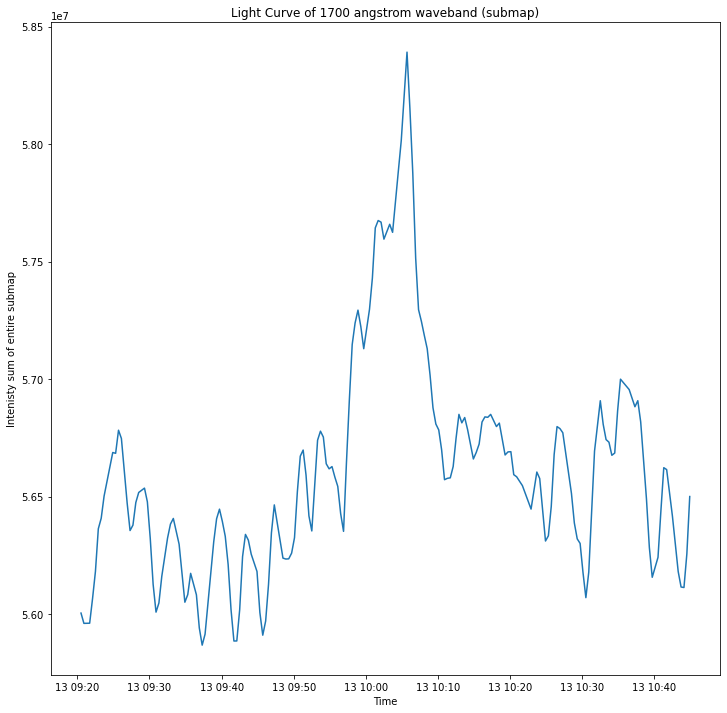

In [12]:
#plotting light curve to see if the peak intensitys occurs when i would expect
maps_1700_intensity = intenisty_sum(maps_1700)
time_axis_1700 = [map.date.datetime for map in maps_1700]

plt.figure(figsize=(12,12))
plt.plot(time_axis_1700,(maps_1700_intensity))
plt.title('Light Curve of 1700 angstrom waveband (submap)')
plt.xlabel('Time')
plt.ylabel('Intenisty sum of entire submap')
plt.show()


# creating submap just over sunspot and plotting light curves

Not sure if this is good or not, adding a small amount to the axis in order to keep sunspot in the image

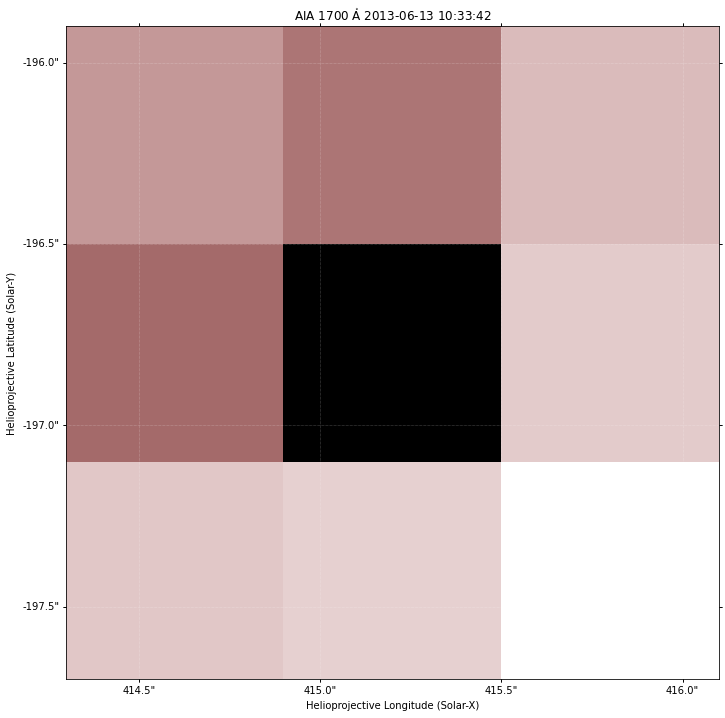

In [7]:

bottom_left = SkyCoord((415.5)* u.arcsec, -197.5 * u.arcsec, frame=maps_1700[0].coordinate_frame)
top_right = SkyCoord((416.5) * u.arcsec, -196 * u.arcsec, frame=maps_1700[0].coordinate_frame)   
submap = maps_1700[160].submap(bottom_left=bottom_left, top_right=top_right)

plt.figure(figsize=(12,12))
submap.plot()

In [8]:
len(maps_1700)

183

In [7]:
# creating submaps of roi and animation to see if it moves 
number_list = np.linspace(0, 10, len(maps_1700))
maps_1700_roi = []
for i,j in zip(maps_1700,number_list):
    bottom_left = SkyCoord((415.5+j)* u.arcsec, -197.5 * u.arcsec, frame=maps_1700[0].coordinate_frame)
    top_right = SkyCoord((416.5+j) * u.arcsec, -196 * u.arcsec, frame=maps_1700[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_1700_roi.append(submap)

# #attempting to get an animation using funcanimation function

# #creating a figure and a keyword arguement for the axes: world coordinate system from my first image
# fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': maps_1700_roi[0].wcs})

# # plotting the first image on the axes i just created, 
# im = maps_1700_roi[0].plot(cmap = 'sdoaia1700',axes=ax)

# # function to update the image and title for each frame of the animation
# def update(i):
#     ax.images[0].set_array(maps_1700_roi[i].data)  # updating the image in my animation to be my image
#     ax.set_title(f"Frame {i + 1}")  # updating the title

# #animation function, takes figure where it will be displayed, the function to update the animation, the amount of frames, sets interval in milliseconds,and loop.
# anim = FuncAnimation(fig, update, frames=len(maps_1700_roi), interval=200, repeat=True)
# plt.show()



# #set name of file and method for saving file
# anim.save('solar_flare_animation_1700_roi_check_9.gif', writer='imagemagick')

# #had to set it equal to anim as when not the the fit was deleting before rendering

KeyboardInterrupt: 

# Light curve of 1700 wavenabd over region of interest

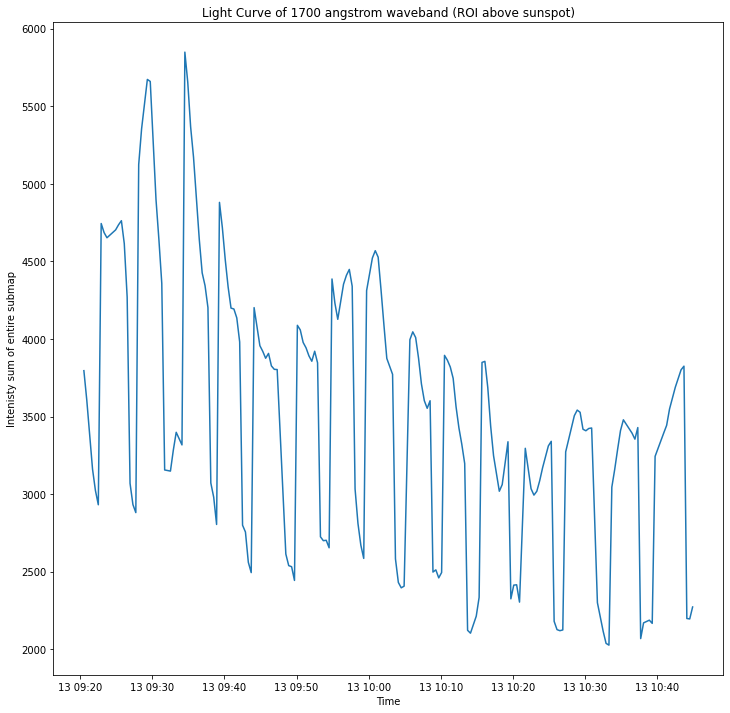

In [10]:
maps_1700_roi_intensity = intenisty_sum(maps_1700_roi)

plt.figure(figsize=(12,12))
plt.plot(time_axis_1700,(maps_1700_roi_intensity))
plt.title('Light Curve of 1700 angstrom waveband (ROI above sunspot)')
plt.xlabel('Time')
plt.ylabel('Intenisty sum of entire submap')
plt.show()

# Light curve of 94 waveband oer region of interest (sunspot)

In [11]:
len(maps_94)

412

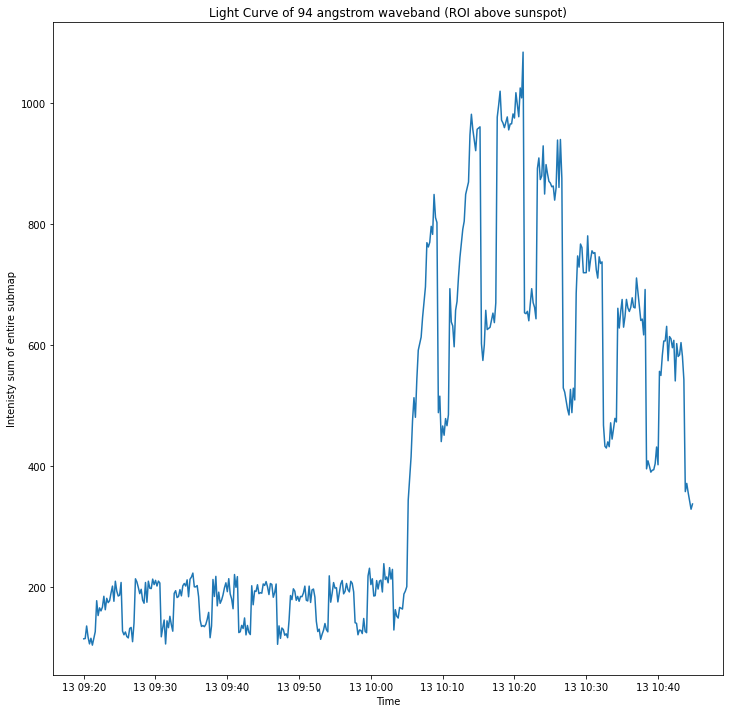

In [12]:
time_axis_94 = [map.date.datetime for map in maps_94]

number_list = np.linspace(0, 10, len(maps_94))
maps_94_roi = []
for i,j in zip(maps_94,number_list):
    bottom_left = SkyCoord((415.5+j)* u.arcsec, -197.5 * u.arcsec, frame=maps_94[0].coordinate_frame)
    top_right = SkyCoord((416.5+j) * u.arcsec, -196 * u.arcsec, frame=maps_94[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_94_roi.append(submap)

maps_94_roi_intensity = intenisty_sum(maps_94_roi)

plt.figure(figsize=(12,12))
plt.plot(time_axis_94,(maps_94_roi_intensity))
plt.title('Light Curve of 94 angstrom waveband (ROI above sunspot)')
plt.xlabel('Time')
plt.ylabel('Intenisty sum of entire submap')
plt.show()

# Light curve of 171 waveband over region of interest (sunspot)

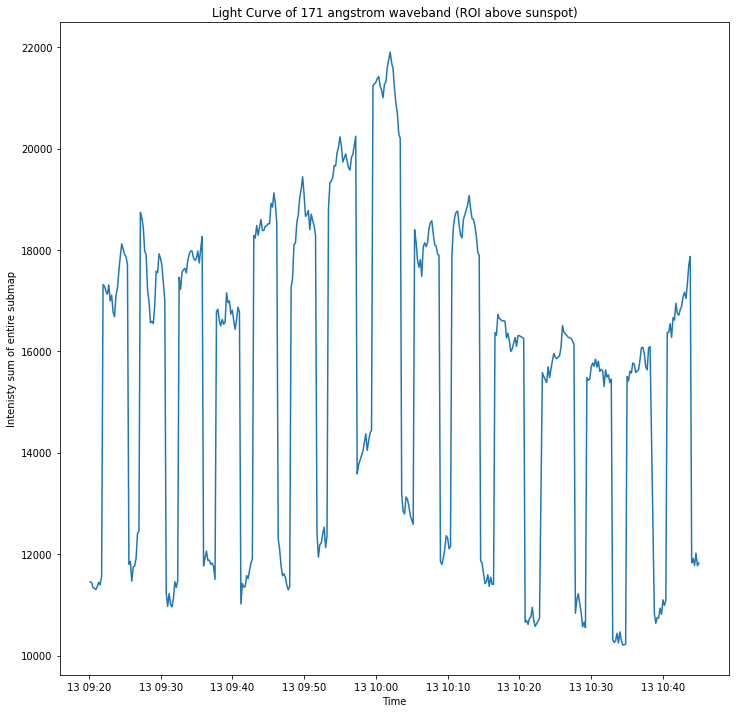

In [13]:
time_axis_171 = [map.date.datetime for map in maps_171]

number_list = np.linspace(0, 10, len(maps_171))
maps_171_roi = []
for i,j in zip(maps_171,number_list):
    bottom_left = SkyCoord((415.5+j)* u.arcsec, -197.5 * u.arcsec, frame=maps_171[0].coordinate_frame)
    top_right = SkyCoord((416.5+j) * u.arcsec, -196 * u.arcsec, frame=maps_171[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_171_roi.append(submap)

maps_171_roi_intensity = intenisty_sum(maps_171_roi)

plt.figure(figsize=(12,12))
plt.plot(time_axis_171,(maps_171_roi_intensity))
plt.title('Light Curve of 171 angstrom waveband (ROI above sunspot)')
plt.xlabel('Time')
plt.ylabel('Intenisty sum of entire submap')
plt.show()

# Light curve over region of interest (sunspot)

ValueError: x and y must have same first dimension, but have shapes (283,) and (183,)

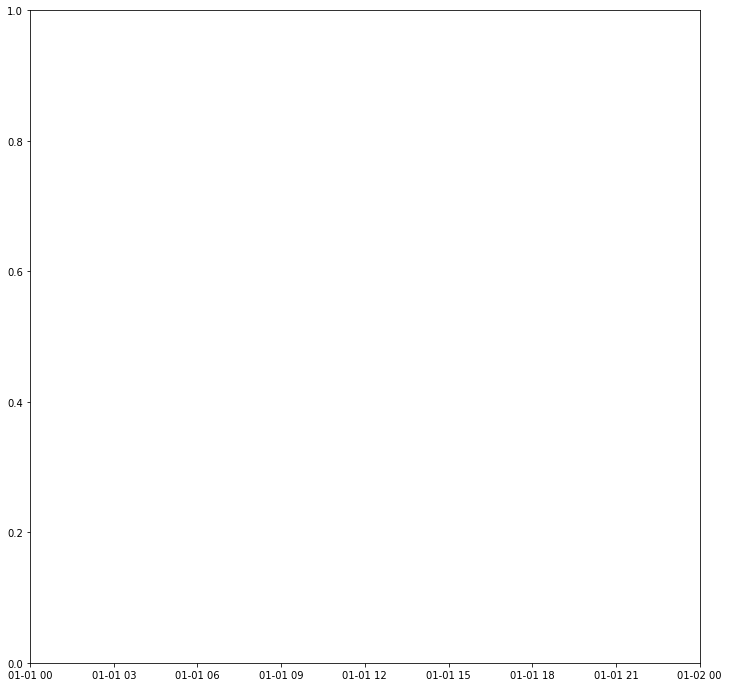

In [40]:
time_axis_304 = [map.date.datetime for map in maps_304]

umber_list = np.linspace(0, 10, len(maps_304))
maps_304_roi = []
for i,j in zip(maps_304,number_list):
    bottom_left = SkyCoord((415.5+j)* u.arcsec, -197.5 * u.arcsec, frame=maps_304[0].coordinate_frame)
    top_right = SkyCoord((416.5+j) * u.arcsec, -196 * u.arcsec, frame=maps_304[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_304_roi.append(submap)

maps_304_roi_intensity = intenisty_sum(maps_304_roi)

plt.figure(figsize=(12,12))
plt.plot(time_axis_304,(maps_304_roi_intensity))
plt.title('Light Curve of 304 angstrom waveband (ROI above sunspot)')
plt.xlabel('Time')
plt.ylabel('Intenisty sum of entire submap')
plt.show()

# plotting light curves of a bigger region 

Trying now for bigger region not moving the axis at all

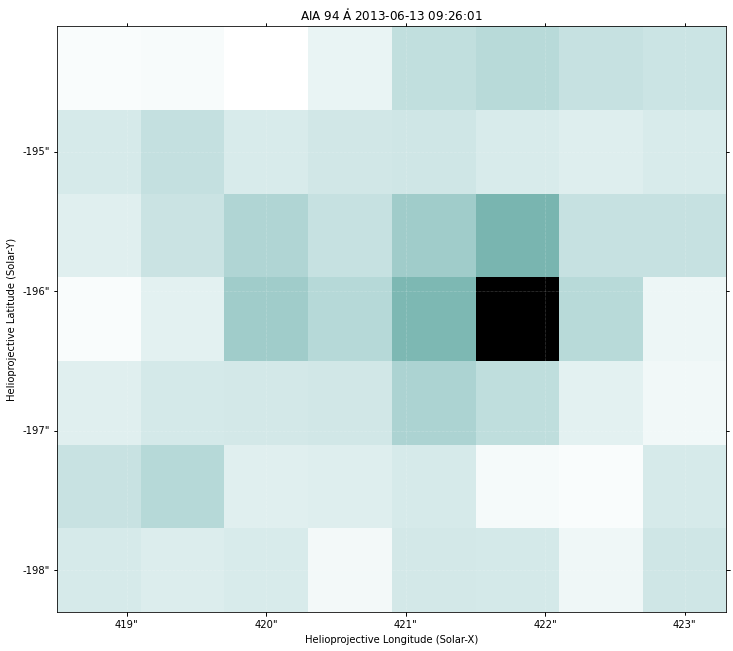

In [38]:

bottom_left = SkyCoord((419)* u.arcsec, -198 * u.arcsec, frame=maps_94[0].coordinate_frame)
top_right = SkyCoord((423) * u.arcsec, -194.5 * u.arcsec, frame=maps_94[0].coordinate_frame)   
submap = maps_94[30].submap(bottom_left=bottom_left, top_right=top_right)

plt.figure(figsize=(12,12))
submap.plot()
plt.savefig(fname = '94Image_flare_submap.jpeg',format="jpeg", bbox_inches="tight")


# maps_1700_roi = []
# for i in maps_1700:
#     bottom_left = SkyCoord((417)* u.arcsec, -198.5 * u.arcsec, frame=maps_1700[50].coordinate_frame)
#     top_right = SkyCoord((420) * u.arcsec, -195 * u.arcsec, frame=maps_1700[50].coordinate_frame)       
#     submap = i.submap(bottom_left=bottom_left, top_right=top_right)
#     maps_1700_roi.append(submap)

# intensity_1700 = intenisty_sum(maps_1700_roi)

# plt.figure(figsize = (12,12))
# plt.plot(time_axis_1700,intensity_1700)
# plt.xlabel('Time (minutes)',fontsize = 22)
# plt.ylabel('Intensity',fontsize = 22)
# plt.title('Light Curve of ROI - 1700Å',fontsize = 23)
# plt.savefig(fname = '1700Image_lightcurve.jpeg',format="jpeg", bbox_inches="tight")


# #attempting to get an animation using funcanimation function

# #creating a figure and a keyword arguement for the axes: world coordinate system from my first image
# fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': maps_1700_roi[0].wcs})

# # plotting the first image on the axes i just created, 
# im = maps_1700_roi[0].plot(cmap = 'sdoaia1700',axes=ax)

# # function to update the image and title for each frame of the animation
# def update(i):
#     ax.images[0].set_array(maps_1700_roi[i].data)  # updating the image in my animation to be my image
#     ax.set_title(f"Frame {i + 1}")  # updating the title

# #animation function, takes figure where it will be displayed, the function to update the animation, the amount of frames, sets interval in milliseconds,and loop.
# anim = FuncAnimation(fig, update, frames=len(maps_1700_roi), interval=200, repeat=True)
# plt.show()



# #set name of file and method for saving file
# anim.save('solar_flare_animation_1700_roi_check_10_biggerarea.gif', writer='imagemagick')

# #had to set it equal to anim as when not the the fit was deleting before rendering

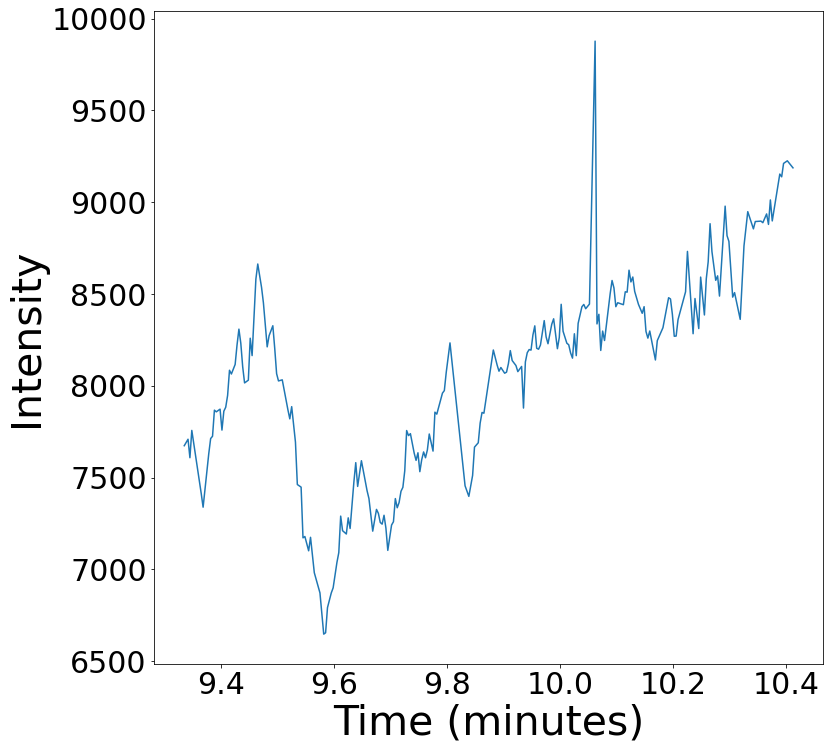

In [367]:
# bottom_left = SkyCoord((419)* u.arcsec, -198 * u.arcsec, frame=maps_1700[0].coordinate_frame)
# top_right = SkyCoord((423) * u.arcsec, -194.5 * u.arcsec, frame=maps_1700[0].coordinate_frame)   
# submap = maps_1700[100].submap(bottom_left=bottom_left, top_right=top_right)

# plt.figure(figsize=(12,12))
# submap.plot()
# plt.savefig(fname = '1700Image_flare_submap.jpeg',format="jpeg", bbox_inches="tight")

time_axis_304 = [map.date.datetime for map in maps_304]
time_float_list_304 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_axis_304
]


maps_304_roi = []
for i in maps_304:
    bottom_left = SkyCoord((417)* u.arcsec, -198.5 * u.arcsec, frame=maps_304[50].coordinate_frame)
    top_right = SkyCoord((420) * u.arcsec, -195 * u.arcsec, frame=maps_304[50].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_304_roi.append(submap)

intensity_304 = intenisty_sum(maps_304_roi)

plt.figure(figsize = (12,12))
plt.plot(time_float_list_304[0:225],intensity_304[0:225])
plt.xlabel('Time (minutes)',fontsize = 41)
plt.ylabel('Intensity',fontsize = 41)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
# plt.title('Light Curve of ROI - 304Å',fontsize = 23)
plt.savefig(fname = '304Image_lightcurve_bigger.jpeg',format="jpeg", bbox_inches="tight")

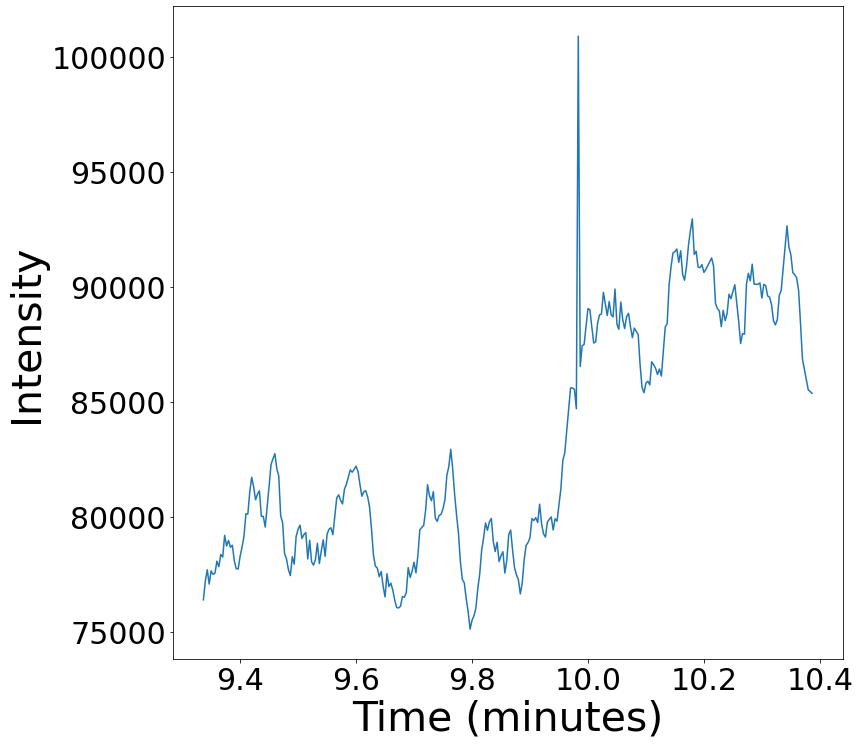

In [366]:
# bottom_left = SkyCoord((419)* u.arcsec, -198 * u.arcsec, frame=maps_1700[0].coordinate_frame)
# top_right = SkyCoord((423) * u.arcsec, -194.5 * u.arcsec, frame=maps_1700[0].coordinate_frame)   
# submap = maps_1700[100].submap(bottom_left=bottom_left, top_right=top_right)

# plt.figure(figsize=(12,12))
# submap.plot()
# plt.savefig(fname = '1700Image_flare_submap.jpeg',format="jpeg", bbox_inches="tight")

time_axis_171 = [map.date.datetime for map in maps_171]
time_float_list_171 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_axis_171
]

maps_171_roi = []
for i in maps_171:
    bottom_left = SkyCoord((417)* u.arcsec, -198.5 * u.arcsec, frame=maps_171[50].coordinate_frame)
    top_right = SkyCoord((420) * u.arcsec, -195 * u.arcsec, frame=maps_171[50].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_171_roi.append(submap)

intensity_171 = intenisty_sum(maps_171_roi)

plt.figure(figsize = (12,12))
plt.plot(time_float_list_171[0:300],intensity_171[0:300])
plt.xlabel('Time (minutes)',fontsize = 41)
plt.ylabel('Intensity',fontsize =41)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
# plt.title('Light Curve of ROI - 171Å',fontsize =23)
plt.savefig(fname = '171Image_lightcurve_bigger.jpeg',format="jpeg", bbox_inches="tight")

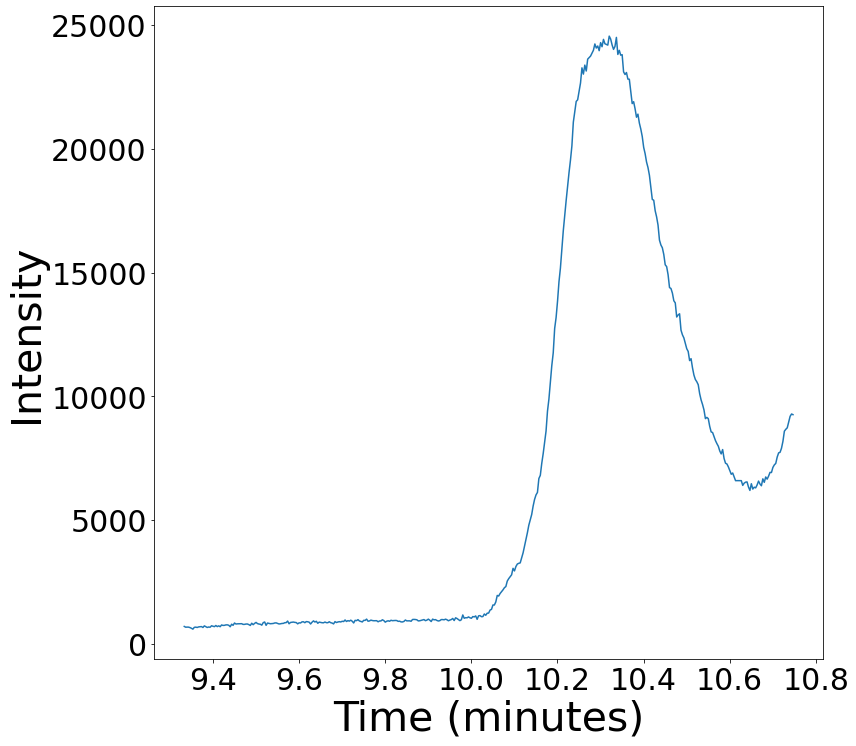

In [368]:
time_axis_94 = [map.date.datetime for map in maps_94]
time_float_list_94 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_axis_94
]
maps_94_roi = []
for i in maps_94:
    bottom_left = SkyCoord((417)* u.arcsec, -198.5 * u.arcsec, frame=maps_94[50].coordinate_frame)
    top_right = SkyCoord((420) * u.arcsec, -195 * u.arcsec, frame=maps_94[50].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_94_roi.append(submap)

intensity_94 = intenisty_sum(maps_94_roi)

plt.figure(figsize = (12,12))
plt.plot(time_float_list_94,intensity_94)
plt.xlabel('Time (minutes)',fontsize = 41)
plt.ylabel('Intensity',fontsize = 41)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
# plt.title('Light Curve of ROI - 94Å',fontsize = 23)
plt.savefig(fname = '94Image_lightcurve_bigger.jpeg',format="jpeg", bbox_inches="tight")

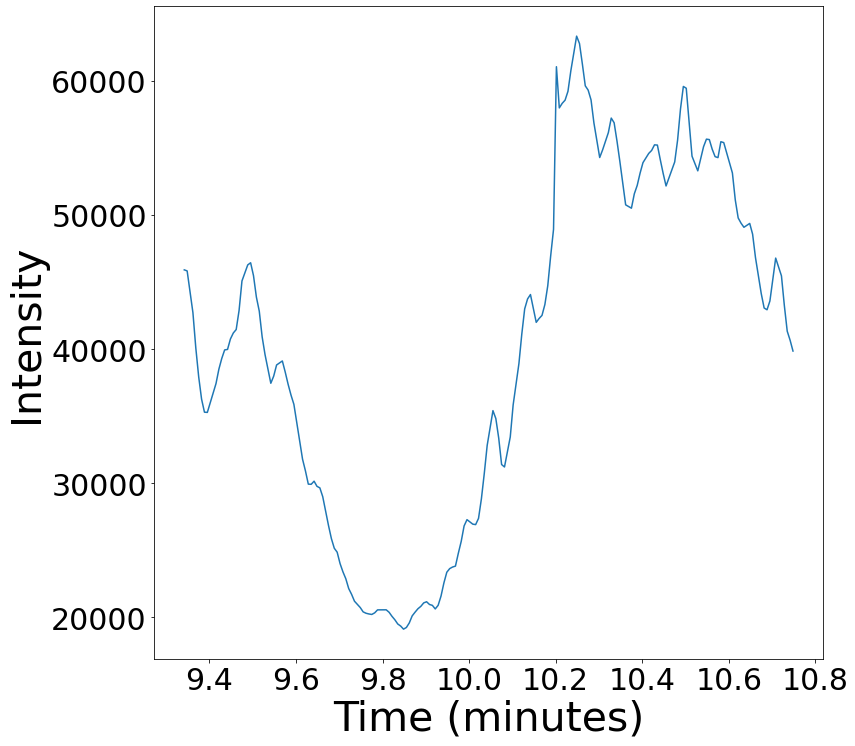

In [365]:

time_axis_1700 = [map.date.datetime for map in maps_1700]
time_float_list_1700 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_axis_1700
]
maps_1700_roi = []
for i in maps_1700:
    bottom_left = SkyCoord((417)* u.arcsec, -198.5 * u.arcsec, frame=maps_1700[50].coordinate_frame)
    top_right = SkyCoord((420) * u.arcsec, -195 * u.arcsec, frame=maps_1700[50].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_1700_roi.append(submap)

intensity_1700 = intenisty_sum(maps_1700_roi)

plt.figure(figsize = (12,12))
plt.plot(time_float_list_1700,intensity_1700)
plt.xlabel('Time (minutes)',fontsize = 41)
plt.ylabel('Intensity',fontsize =41)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

# plt.title('Light Curve of ROI - 94Å',fontsize = 23)
plt.savefig(fname = '1700Image_lightcurve_bigger.jpeg',format="jpeg", bbox_inches="tight")

 Morlet Wavelet Analysis
========================
Wavelet software was provided by C. Torrence and G. Compo,
      and is available at URL: http://paos.colorado.edu/research/wavelets/''.

 Reference: Torrence, C. and G. P. Compo, 1998: A Practical Guide to
          Wavelet Analysis. <I>Bull. Amer. Meteor. Soc.</I>, 79, 61-78.




Map_intensity is the weird mapswith moving axis

\\\intensity_maps is defined in one spot

### First trying the function given from the Torrence Compo paper

#

In [304]:
from wavelet_function import wavelet

In [193]:
len(maps_94_roi_intensity)

412

In [196]:
wavelet_transform_94 , fourier_period_94, scale_94, COI_94 = wavelet(maps_94_roi_intensity,12)#s0 = 24,dj = 0.5)

T = s delta t

Locator attempting to generate 9094 ticks ([0.0, ..., 5455.800000000001]), which exceeds Locator.MAXTICKS (1000).


[[  38.30120605   33.27358889   24.59774975 ...   22.62339645
    31.34111871   37.61405555]
 [  53.92450625   47.26543097   34.74487057 ...   24.61408755
    40.5357303    51.6373136 ]
 [  67.83548806   60.53596009   49.01250656 ...   62.47509342
    67.11702073   69.71318854]
 ...
 [ 592.56811639  587.74778971  582.90647496 ...  606.89723714
   602.14342055  597.36685555]
 [2231.60509142 2231.47906975 2231.35352836 ... 2231.98574371
  2231.85845793 2231.73156398]
 [5455.54790649 5455.54781519 5455.54772425 ... 5455.54818228
  5455.54809005 5455.54799812]]


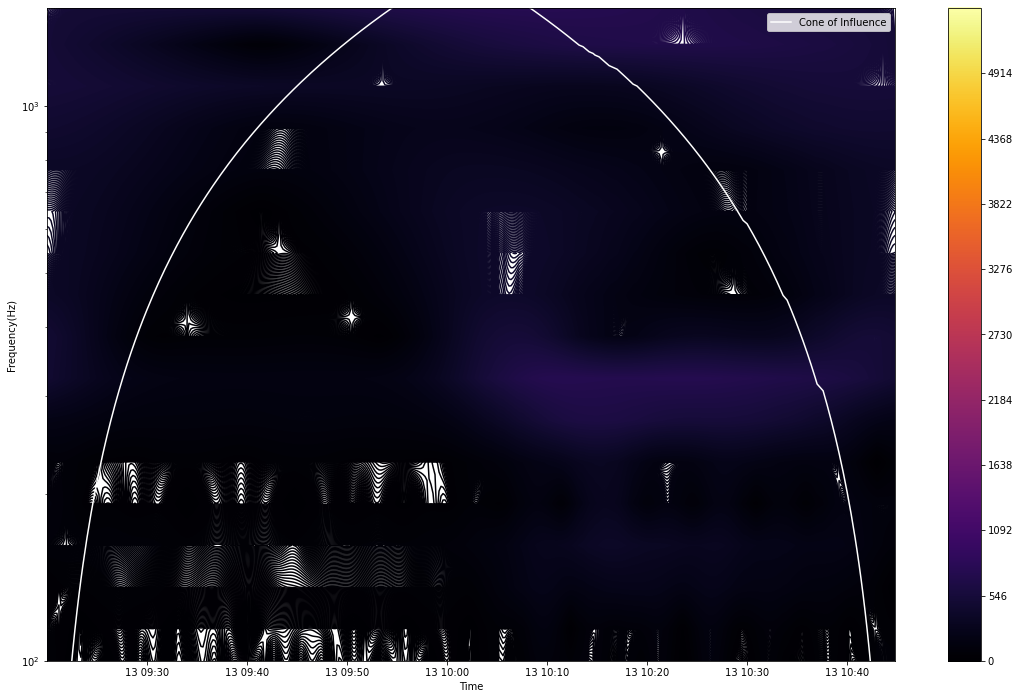

In [200]:
wavelet_power_94 = abs(wavelet_transform_94)
print(wavelet_power_94)

plt.figure(figsize=(19,12))
plt.contour(time_axis_94,scale_94,wavelet_power_94,levels = 10000, cmap = 'inferno')

plt.plot(time_axis_94, COI_94, label='Cone of Influence',color = 'white')
plt.colorbar()
plt.yscale('log')
plt.ylabel('Frequency(Hz)')
plt.xlabel('Time')
plt.ylim(100,1500)

plt.legend()
plt.show()

In [30]:
def wavelet_func_plot(maps_roi_intensity,cadence,maps_list):

    time_axis = [map.date.datetime for map in maps_list]


    wavelet_transform , fourier_period, scale, COI = wavelet(maps_roi_intensity[0:len(maps_list)-1],cadence)

    wavelet_power = abs(wavelet_transform)**2
    

    plt.figure(figsize=(15,12))
    plt.contour(time_axis[0:len(maps_list)-1],fourier_period,wavelet_power,levels = 15000, cmap = 'inferno')

    plt.plot(time_axis[0:len(maps_list)-1], COI, label='Cone of Influence', linestyle='--')
    plt.colorbar()

    plt.ylabel('Frequency(Hz)')
    plt.xlabel('Time')
    plt.ylim(0,1300)

    plt.legend()
    plt.show()

Locator attempting to generate 13057 ticks ([0.0, ..., 3916800.0]), which exceeds Locator.MAXTICKS (1000).


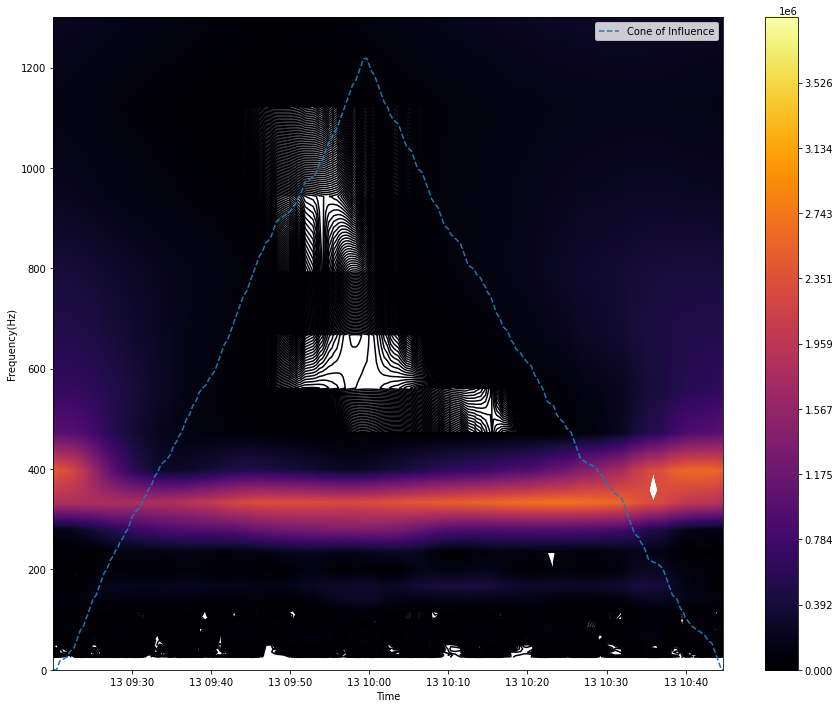

Locator attempting to generate 12049 ticks ([0.0, ..., 48192000.0]), which exceeds Locator.MAXTICKS (1000).


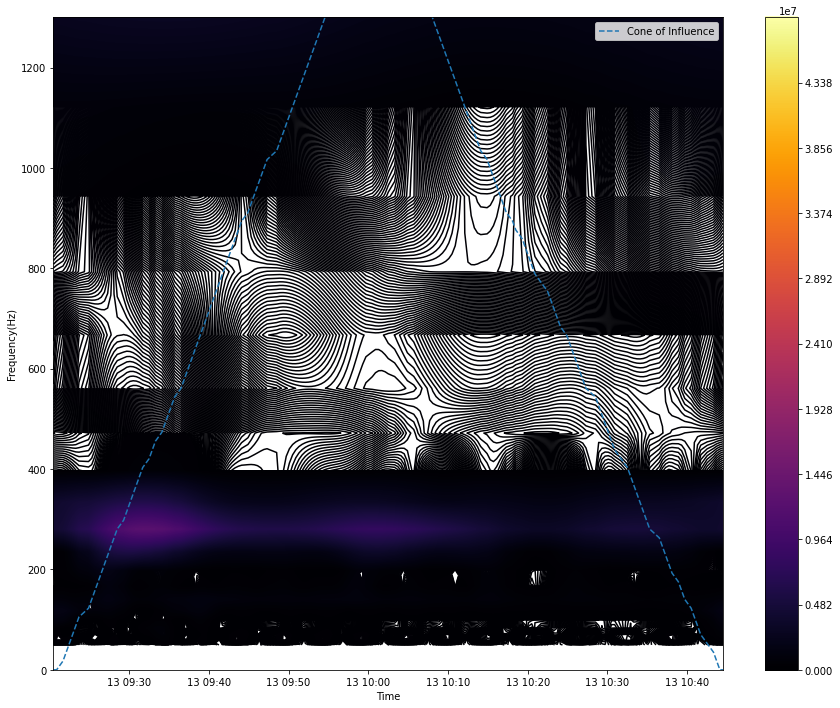

In [171]:
wavelet_func_plot(maps_304_roi_intensity,12,maps_304)
wavelet_func_plot(maps_1700_roi_intensity,24,maps_1700)

Locator attempting to generate 13756 ticks ([0.0, ..., 687750000.0]), which exceeds Locator.MAXTICKS (1000).


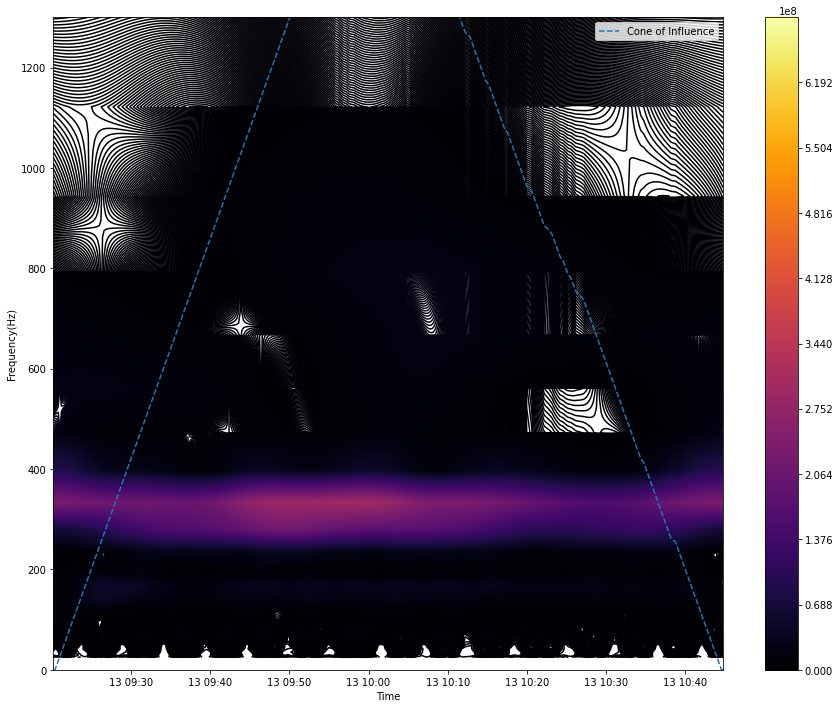

In [176]:
wavelet_func_plot(maps_171_roi_intensity,12,maps_171)

### attempting to use the PyWavelets Documentation

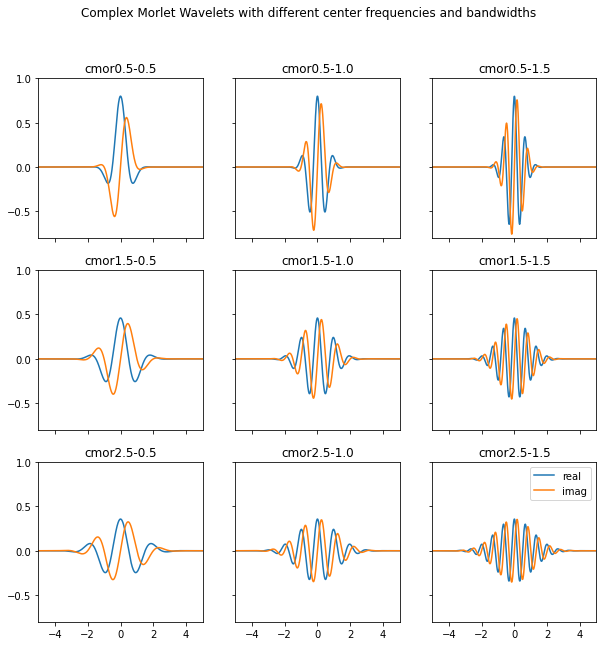

In [52]:
# plot complex morlet wavelets with different center frequencies and bandwidths
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real")
    ax.plot(x, np.imag(psi), label="imag")
    ax.set_title(wavelet)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-0.8, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with different center frequencies and bandwidths")
plt.show()

In [282]:
# def plot_wavelet(time, data, wavelet, title, ax):
#     widths = np.geomspace(1, 10000, num=24)
#     cwtmatr, freqs = pywt.cwt(
#         data, widths, wavelet, sampling_period=24
#     )
#     cwtmatr = np.abs(cwtmatr[:-1, :-1])
#     pcm = ax.pcolormesh(time, 1/freqs, cwtmatr)
#     ax.set_yscale("log")
#     ax.set_xlabel("Time (s)")
#     ax.set_ylabel("Frequency (Hz)")
#     ax.set_title(title)
#     plt.colorbar(pcm, ax=ax)
#     return ax


# # perform CWT with different wavelets on same signal and plot results
# wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
# fig, axs = plt.subplots(3, 3, figsize=(25, 15), sharex=True)
# for ax, wavelet in zip(axs.flatten(), wavelets):
#     plot_wavelet(time_axis_1700, maps_1700_roi_intensity, wavelet, wavelet, ax)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.suptitle("Scaleograms of the same signal with different wavelets")
# plt.show()

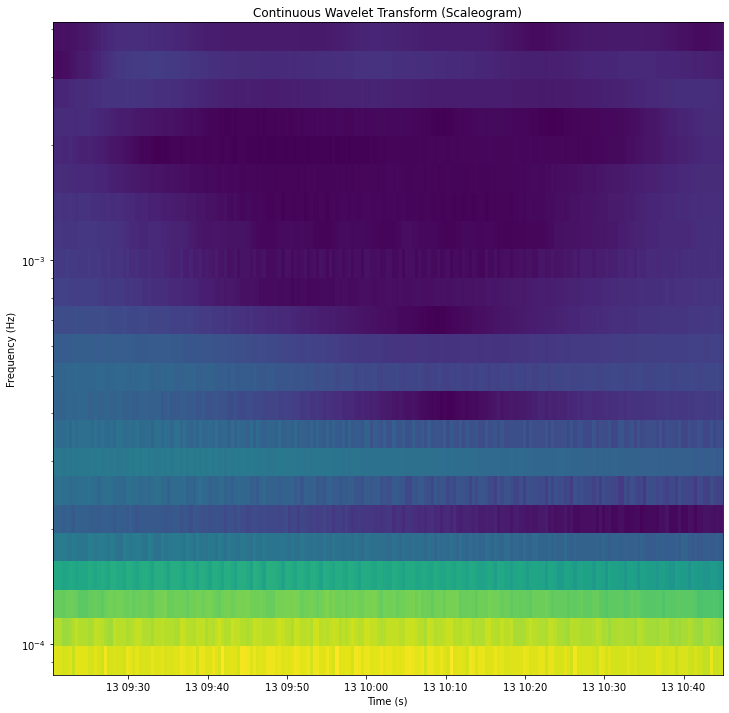

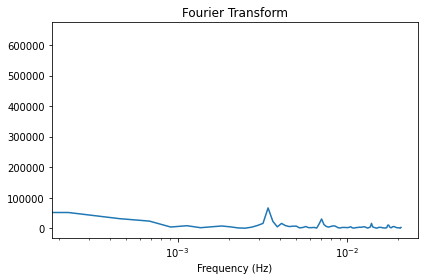

In [ ]:
# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(10, 500, num=24)
cwtmatr, freqs = pywt.cwt(maps_1700_roi_intensity, widths, wavelet, sampling_period=24)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)

plt.figure(figsize=(12,12))
pcm = plt.pcolormesh(time_axis_1700, freqs, cwtmatr)
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Continuous Wavelet Transform (Scaleogram)")
plt.colorbar(pcm, ax=axs[0])
plt.show()
# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(maps_1700_roi_intensity)
xf = rfftfreq(len(maps_1700_roi_intensity), 24)
plt.semilogx(xf, np.abs(yf))
plt.xlabel("Frequency (Hz)")
plt.title("Fourier Transform")
plt.tight_layout()
plt.show()

# using slit method to analyse the flare ribbon 

In [297]:
# maps_94 = Fits_to_maps('AIA_94_prep_rot_done')
# maps_94 = sorted(maps_94,key = lambda m:m.date)


In [296]:
# plt.figure(figsize=(12,12))
# maps_94[50].plot()
# plt.show()

In [295]:
# line_coords = SkyCoord([[370, -200], [390, -195]], unit=(u.arcsec, u.arcsec), frame=maps_94[150].coordinate_frame)

# # line_coords = SkyCoord([[360, -160], [460, -240]], unit=(u.arcsec, u.arcsec), frame=submaps_1700_prepped[17].coordinate_frame)


#     # top_right = SkyCoord(500 * u.arcsec, -150 * u.arcsec, frame=i.coordinate_frame)  
#     # 
# intensity_coords = sunpy.map.pixelate_coord_path(maps_94[150], line_coords)
# intensity = sunpy.map.sample_at_coords(maps_94[150], intensity_coords) 

# angular_separation = intensity_coords.separation(intensity_coords[0]).to(u.arcsec)

# fig = plt.figure(figsize=(20, 10))
# ax1 = fig.add_subplot(121, projection=maps_94[50])
# maps_94[150].plot(axes=ax1)
# ax1.plot_coord(intensity_coords)
# ax1.plot_coord(line_coords[0], marker="o", color="blue", label="start")
# ax1.plot_coord(line_coords[1], marker="o", color="green", label="end")
# ax1.legend()

# ax2 = fig.add_subplot(122)
# ax2.plot(angular_separation, intensity)
# ax2.set_xlabel("Angular distance along slit [arcsec]")
# ax2.set_ylabel(f"Intensity [{maps_94[150].unit}]")

# plt.show()

# Trying morlet wavelet analysis over an area of nothing 

## first using the funcion from torrence and compo again

Text(0.5, 1.0, 'region of nothing in 1700 waveband')

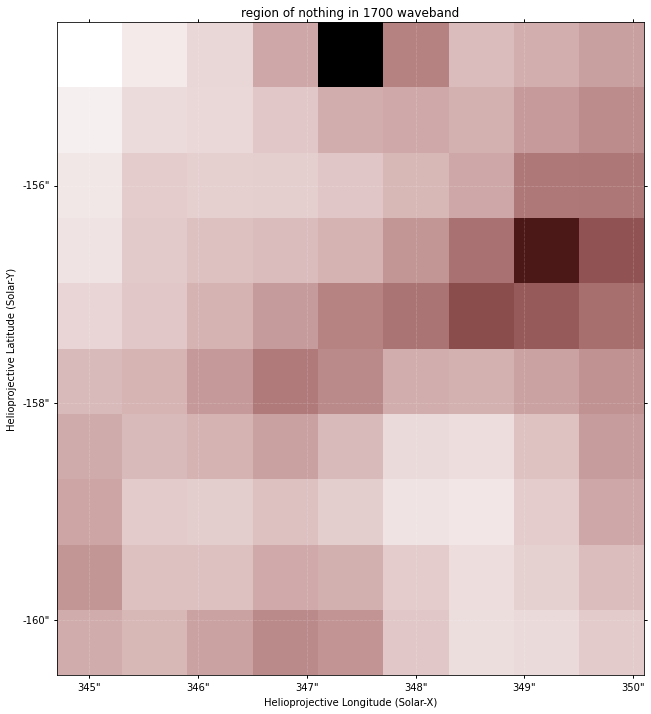

In [324]:
bottom_left = SkyCoord((345)* u.arcsec, -160 * u.arcsec, frame=maps_1700[0].coordinate_frame)
top_right = SkyCoord((350) * u.arcsec, -155 * u.arcsec, frame=maps_1700[0].coordinate_frame)   
submap = maps_1700[0].submap(bottom_left=bottom_left, top_right=top_right)

plt.figure(figsize=(12,12))
submap.plot()
plt.title('region of nothing in 1700 waveband')

In [325]:
intensity_1700_roi = []
for i in (maps_1700):
    bottom_left = SkyCoord((345)* u.arcsec, -160 * u.arcsec, frame=maps_1700[0].coordinate_frame)
    top_right = SkyCoord((350) * u.arcsec, -155 * u.arcsec, frame=maps_1700[0].coordinate_frame)         
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    intensity_1700_roi.append(submap)

intensity_1700_nothing_roi = intenisty_sum(intensity_1700_roi)

TypeError: Image data of dtype complex128 cannot be converted to float

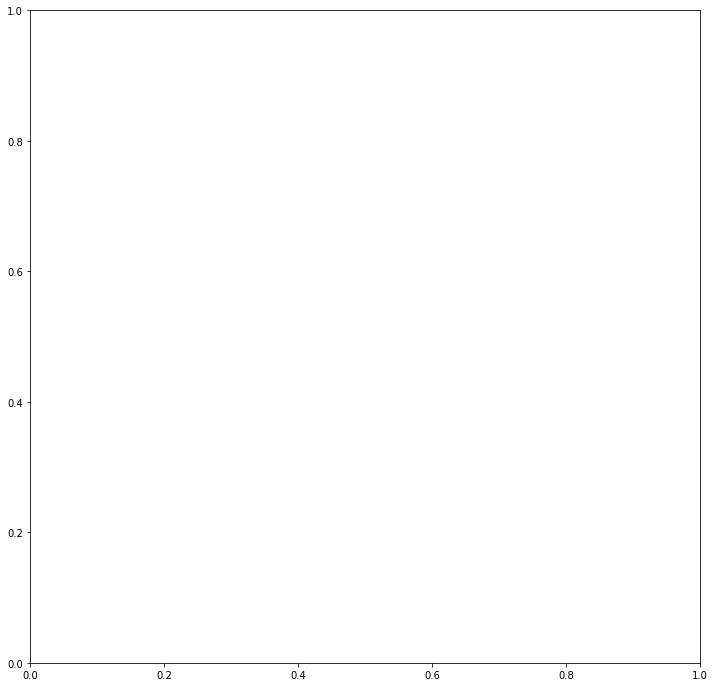

In [336]:
wave, period, scale, coi = wavelet(intensity_1700_nothing_roi,24,pad  = 1,dj = 0.2)


plt.figure(figsize=(12,12))
plt.pcolormesh(period,scale,wave[0:33,0:33])#,shading = 'gouraud')
print()

/Users/maxrobertson/opt/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Users/maxrobertson/opt/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/Users/maxrobertson/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


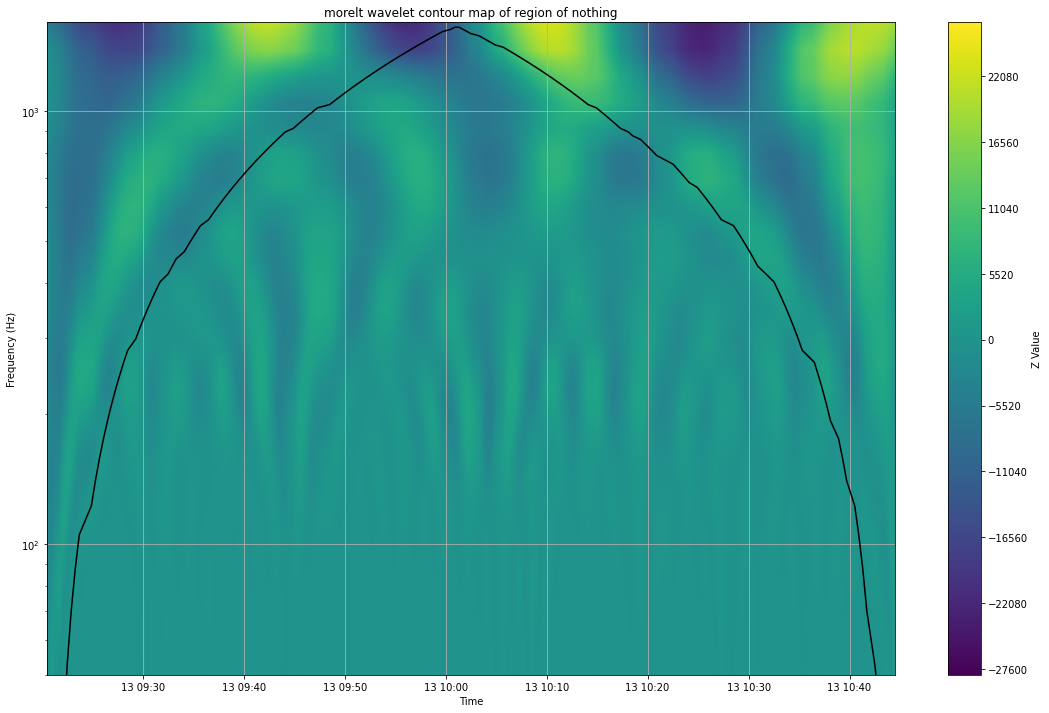

In [299]:
plt.figure(figsize=(19, 12))
plt.contourf(time_axis_1700[0:182], period, wave, levels=1000, cmap='viridis')  
plt.colorbar(label="Z Value")  
plt.title("morelt wavelet contour map of region of nothing")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
plt.grid(True)
plt.plot(time_axis_1700[0:182],coi,color = 'black')
plt.ylim(50,1600)
plt.show()

# Now trying over an area with the sunspot

Text(0.5, 1.0, 'REgion of sunspot (seems to move out of frame by end of flare)')

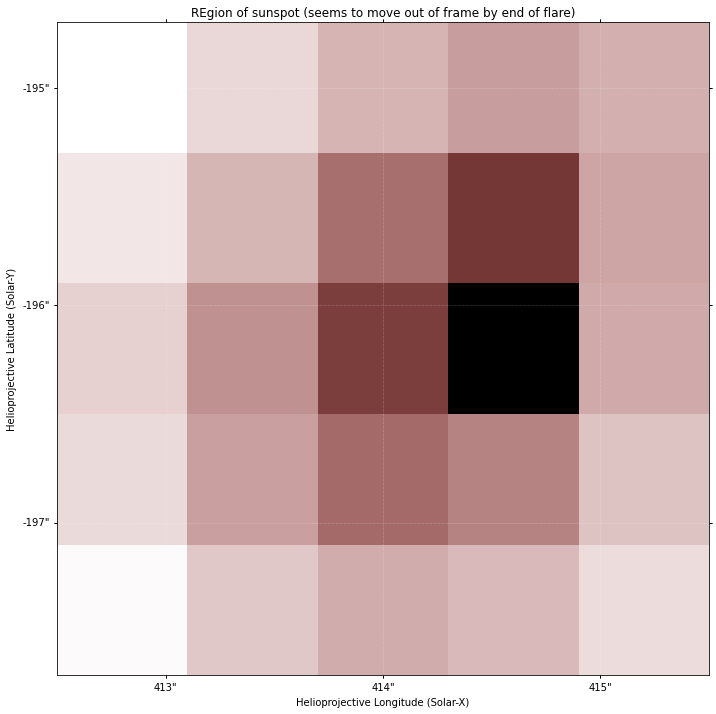

In [300]:
bottom_left = SkyCoord((413)* u.arcsec, -197.25 * u.arcsec, frame=maps_1700[0].coordinate_frame)
top_right = SkyCoord((415) * u.arcsec, -195* u.arcsec, frame=maps_1700[0].coordinate_frame)   
submap = maps_1700[0].submap(bottom_left=bottom_left, top_right=top_right)

plt.figure(figsize=(12,12))
submap.plot()
plt.title('REgion of sunspot (seems to move out of frame by end of flare)')

In [322]:
intensity_1700_roi = []
for i in (maps_1700):
    bottom_left = SkyCoord((413)* u.arcsec, -197.25 * u.arcsec, frame=maps_1700[0].coordinate_frame)
    top_right = SkyCoord((415) * u.arcsec, -195* u.arcsec, frame=maps_1700[0].coordinate_frame)      
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    intensity_1700_roi.append(submap)

intensity_1700_sunspot_roi = intenisty_sum(intensity_1700_roi)

In [323]:
wave, period, scale, coi = wavelet(intensity_1700_sunspot_roi[0:182],24,pad  = 1,dj = 0.2)

wave_movingaxis, period_movingaxis, scale_movingaxis, coi_movingaxis = wavelet(maps_1700_roi_intensity[0:182],24,pad  = 1,dj = 0.2)



NameError: name 'maps_1700_roi_intensity' is not defined

In [ ]:
plt.pcolormesh(wa)

/Users/maxrobertson/opt/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Users/maxrobertson/opt/anaconda3/lib/python3.9/site-packages/matplotlib/contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/Users/maxrobertson/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


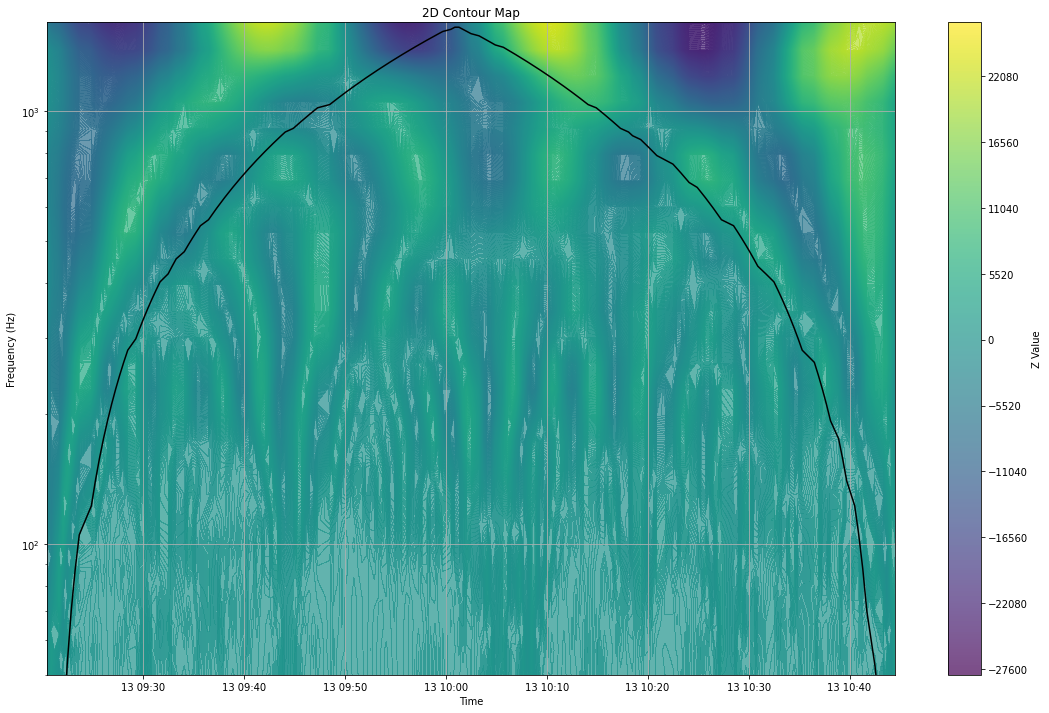

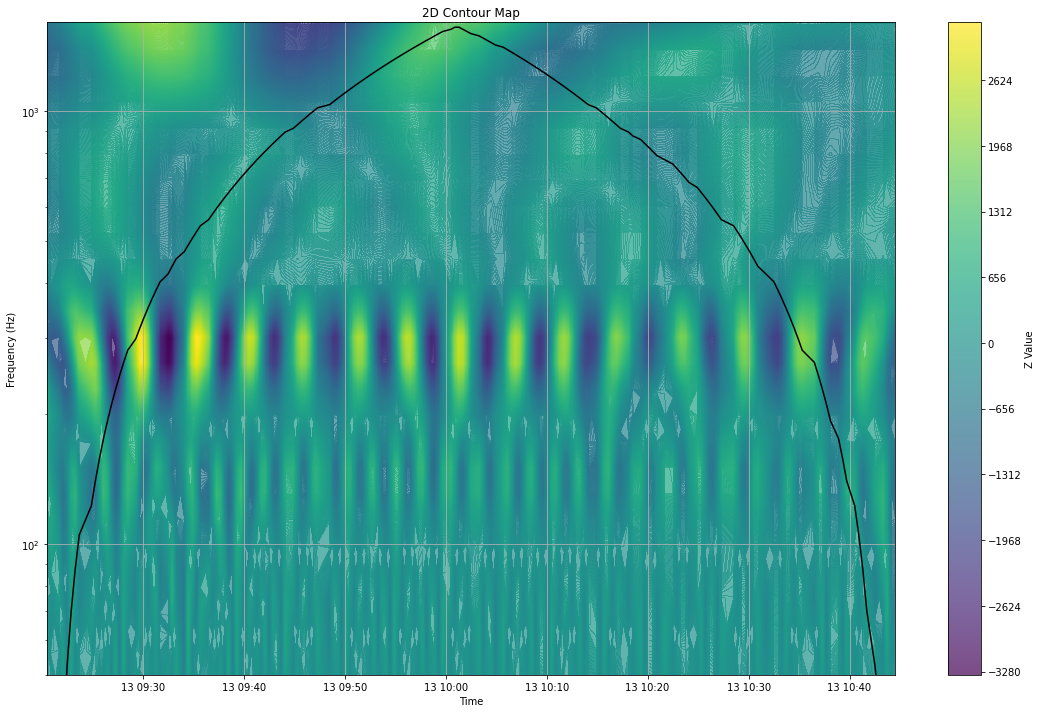

In [311]:
plt.figure(figsize=(19, 12))
# contour = plt.contour(time_axis_1700[0:182], period, wave, levels=1000, cmap='viridis')  
# plt.clabel(contour)#, inline=True, fontsize=8)  
plt.contourf(time_axis_1700[0:182], period, wave, levels=1000, cmap='viridis', alpha=0.7)  
plt.colorbar(label="Z Value")  
plt.title("2D Contour Map")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
plt.grid(True)
plt.plot(time_axis_1700[0:182],coi,color = 'black')
plt.ylim(50,1600)
plt.show()

plt.figure(figsize=(19, 12))
# contour = plt.contour(time_axis_1700[0:182], period, wave, levels=1000, cmap='viridis')  
# plt.clabel(contour)#, inline=True, fontsize=8)  
plt.contourf(time_axis_1700[0:182], period_movingaxis, wave_movingaxis, levels=1000, cmap='viridis', alpha=0.7)  
plt.colorbar(label="Z Value")  
plt.title("2D Contour Map")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.yscale('log')
plt.grid(True)
plt.plot(time_axis_1700[0:182],coi,color = 'black')
plt.ylim(50,1600)
plt.show()

# Now trying the pywt function 

In [184]:
len(intensity_1700_sunspot_roi)

183

In [292]:
# perform CWT
wavelet = "cmor1.5-1.0"
# logarithmic scale for scale as the paper suggests me to use
widths = np.geomspace(1, 1000, num=183)
cwtmatr, freqs = pywt.cwt(maps_1700_roi_intensity, widths, wavelet, sampling_period=24)
# absolute value of complex result gets rid of complext part
cwtmatr = np.abs(cwtmatr)


print(len(cwtmatr))



183


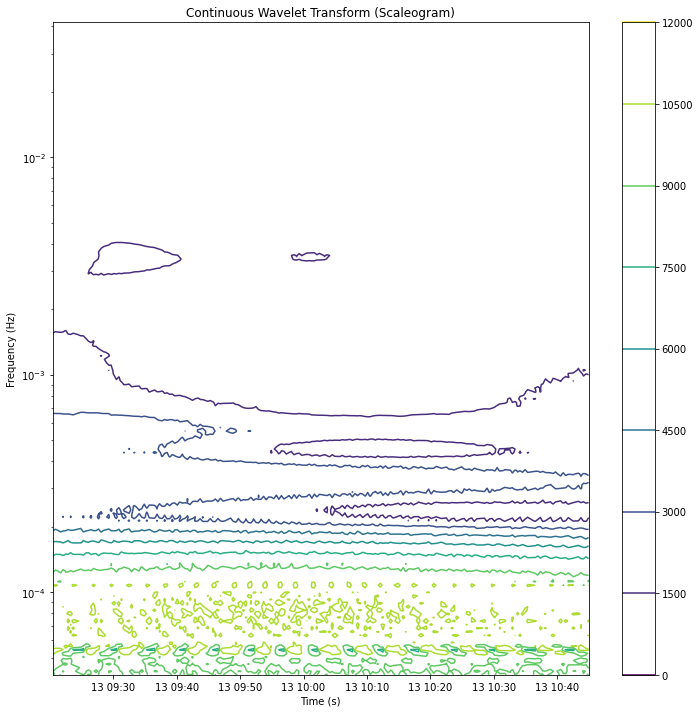

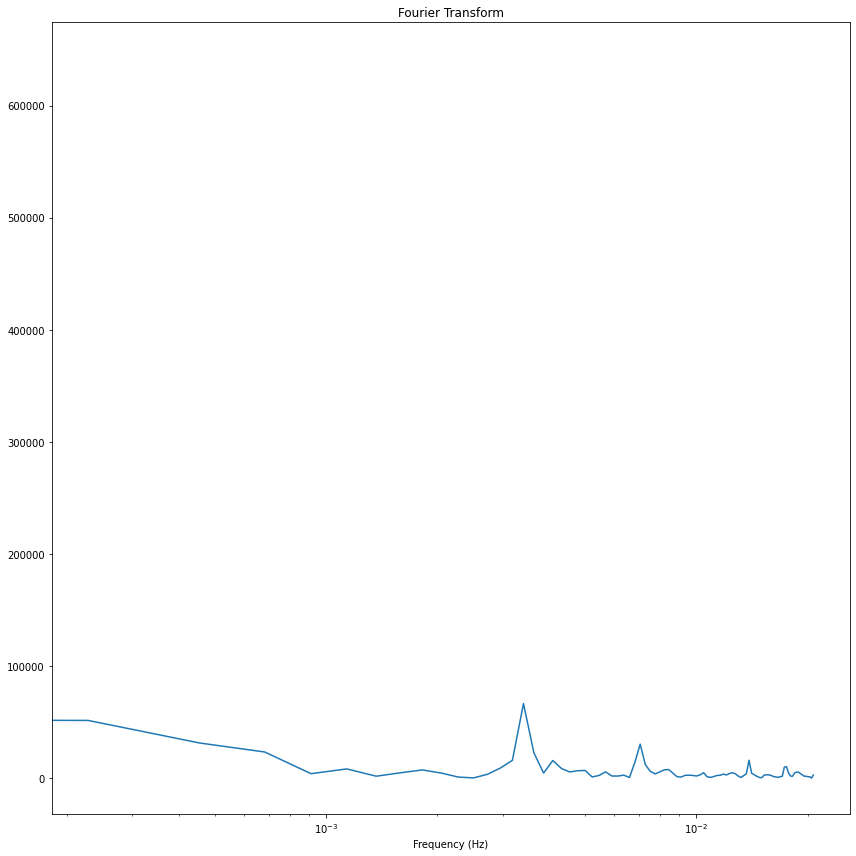

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_857/1239633445.py:35: RuntimeWarning: divide by zero encountered in divide
  period_x_1700 = 1/freqs_1700


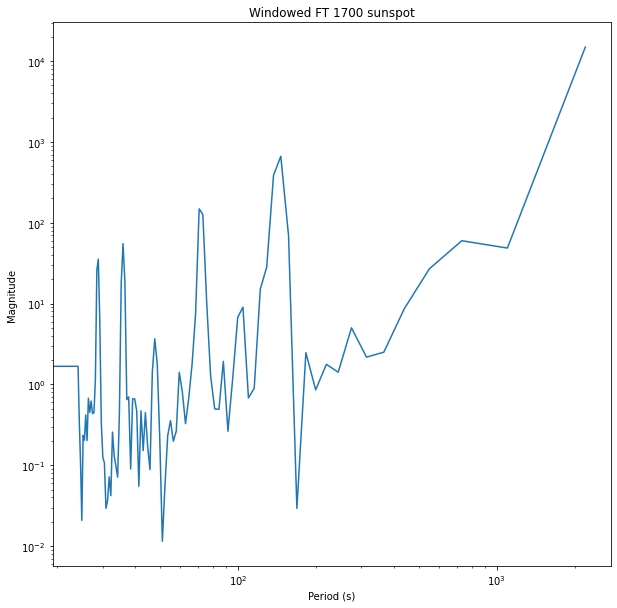

In [312]:
#Morlet wavelet countor plot

plt.figure(figsize=(12,12))
plt.contour(time_axis_1700, freqs, cwtmatr)
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Continuous Wavelet Transform (Scaleogram)")
plt.colorbar()
plt.show()



# basic fourier transfrom of the time series
plt.figure(figsize=(12,12))
yf = rfft(maps_1700_roi_intensity)
xf = rfftfreq(len(maps_1700_roi_intensity), 24)
plt.semilogx(xf, np.abs(yf))
plt.xlabel("Frequency (Hz)")
plt.title("Fourier Transform")
plt.tight_layout()
plt.show()





#windowed fourier transfrom
window = signal.windows.hann(len(maps_1700_roi_intensity))
plt.figure(figsize = (10,10))
sunspot1700_window = window*maps_1700_roi_intensity
fft_result_1700 = np.fft.fft(sunspot1700_window)
fft_sunspot_1700 = (np.abs(fft_result_1700)**2)/np.var(sunspot1700_window)
freqs_1700 = np.fft.fftfreq(len(sunspot1700_window ), 12)
period_x_1700 = 1/freqs_1700
plt.plot(period_x_1700,(fft_sunspot_1700))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Period (s)")
plt.ylabel("Magnitude")
plt.title("Windowed FT 1700 sunspot")
plt.show()

In [320]:
from scipy.signal import spectrogram
from matplotlib.pyplot import pcolormesh

f,t,s = spectrogram(np.array(intensity_304),1000)

print(s)

plt.figure(figsize = (12,12))
plt.pcolormesh(time_axis_1700[0:182], period, wave,cmap = 'viridis',shading = 'gouraud')
plt.show()

[[2.63084368e+08]
 [1.92546869e+11]
 [1.45303626e+11]
 [5.21525160e+10]
 [2.29807164e+10]
 [1.45217165e+10]
 [4.21630592e+09]
 [1.51014939e+10]
 [6.18299263e+09]
 [6.04769351e+09]
 [5.68919510e+09]
 [1.12582123e+09]
 [7.64787287e+08]
 [1.32317639e+08]
 [7.71805274e+08]
 [1.27090963e+09]
 [1.16567239e+09]
 [1.06190638e+09]
 [1.09566234e+09]
 [2.15419268e+09]
 [2.22885984e+09]
 [1.02466259e+09]
 [5.00079151e+08]
 [2.75973246e+08]
 [1.33691760e+08]
 [1.82247552e+08]
 [1.53847567e+08]
 [4.61922248e+08]
 [1.13303100e+08]
 [1.80364600e+08]
 [2.76940274e+08]
 [1.60927690e+08]
 [1.32324903e+08]
 [5.48109290e+06]
 [5.45884607e+07]
 [4.98307641e+06]
 [5.43808721e+07]
 [1.27353184e+08]
 [1.24369108e+07]
 [1.08280572e+08]
 [8.30923149e+06]
 [4.52703319e+07]
 [6.76366828e+07]
 [6.60402984e+07]
 [2.41745076e+07]
 [3.52894196e+07]
 [4.99939260e+07]
 [1.06587168e+08]
 [6.84047209e+07]
 [4.23523984e+07]
 [2.69930782e+07]
 [6.53610243e+07]
 [5.86128492e+07]
 [6.98002140e+07]
 [7.83045513e+07]
 [9.943856

NameError: name 'wave' is not defined

<Figure size 864x864 with 0 Axes>

# making light of 171 of larger image for presnetation 

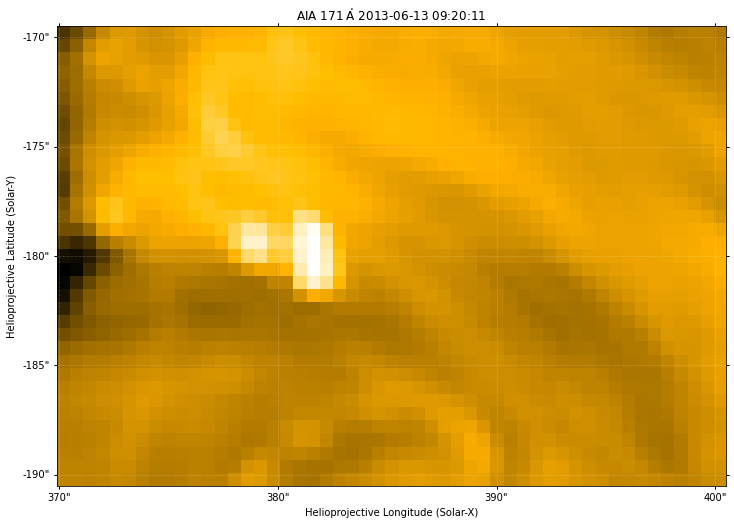

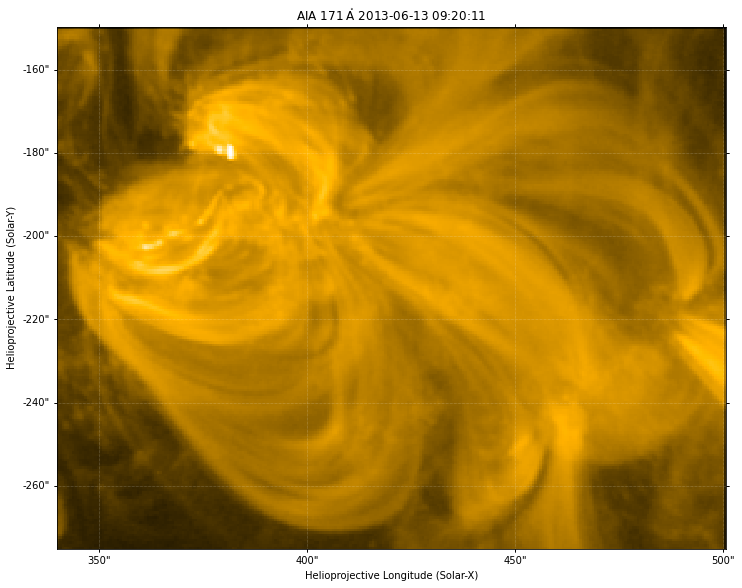

In [348]:

maps_171_roi = []
for i in (maps_171):
    bottom_left = SkyCoord((370)* u.arcsec, -190 * u.arcsec, frame=maps_171[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -170 * u.arcsec, frame=maps_171[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_171_roi.append(submap)

plt.figure(figsize=(12,12))
maps_171_roi[0].plot()
plt.show()

plt.figure(figsize=(12,12))
maps_171[0].plot()
plt.show()

[datetime.datetime(2013, 6, 13, 9, 20, 11, 340000), datetime.datetime(2013, 6, 13, 9, 20, 23, 340000), datetime.datetime(2013, 6, 13, 9, 20, 35, 340000), datetime.datetime(2013, 6, 13, 9, 20, 47, 340000), datetime.datetime(2013, 6, 13, 9, 20, 59, 340000), datetime.datetime(2013, 6, 13, 9, 21, 11, 340000), datetime.datetime(2013, 6, 13, 9, 21, 23, 340000), datetime.datetime(2013, 6, 13, 9, 21, 35, 340000), datetime.datetime(2013, 6, 13, 9, 21, 47, 340000), datetime.datetime(2013, 6, 13, 9, 21, 59, 340000), datetime.datetime(2013, 6, 13, 9, 22, 11, 340000), datetime.datetime(2013, 6, 13, 9, 22, 23, 340000), datetime.datetime(2013, 6, 13, 9, 22, 35, 340000), datetime.datetime(2013, 6, 13, 9, 22, 47, 340000), datetime.datetime(2013, 6, 13, 9, 22, 59, 340000), datetime.datetime(2013, 6, 13, 9, 23, 11, 340000), datetime.datetime(2013, 6, 13, 9, 23, 23, 340000), datetime.datetime(2013, 6, 13, 9, 23, 35, 340000), datetime.datetime(2013, 6, 13, 9, 23, 47, 340000), datetime.datetime(2013, 6, 13,

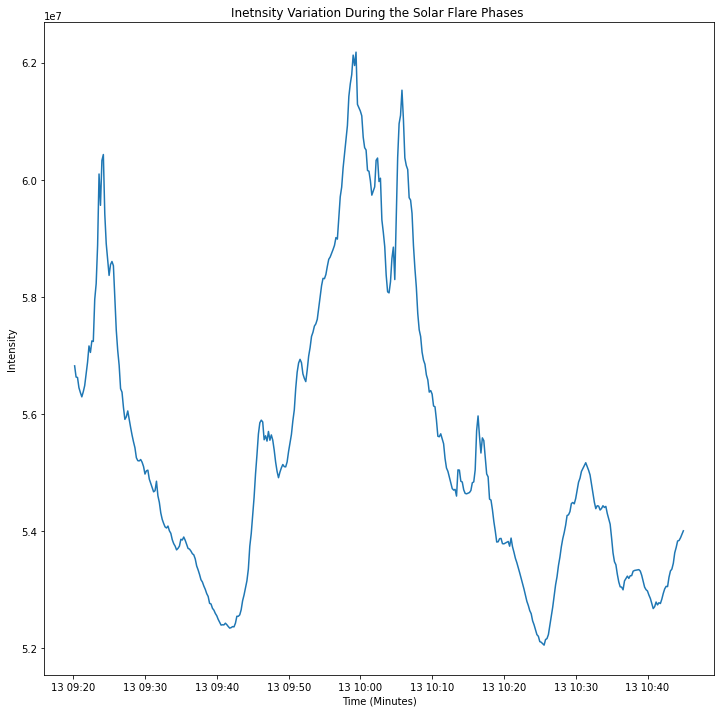

In [279]:
maps_roi_171_intensity = intenisty_sum(maps_171)

# print(time_axis_171[0].time())

# time_171 = []
# for i in np.arange(0,len(time_axis_171)):
#     time = time_axis_171[i].time()
#     time_171.append(time)

print(list(time_171))
print(time_axis_171)



plt.figure(figsize=(12,12))
plt.plot(time_171,maps_roi_171_intensity)
plt.title('Inetnsity Variation During the Solar Flare Phases ')
plt.xlabel('Time (Minutes)')
plt.ylabel('Intensity')
plt.show()

# Getting Images for Presentation

In [ ]:
maps_1700 = Fits_to_maps('AIA_1700_prep_rot_done')
maps_304 = Fits_to_maps('AIA_304_prep_rot_done')
maps_171 = Fits_to_maps('AIA_171_prep_rot_done')
maps_94 = Fits_to_maps('AIA_94_prep_rot_done')

NotADirectoryError: [Errno 20] Not a directory: 'AIA_June_2013_171/aia_lev1_171a_2013_06_13t09_20_11_34z_image_lev1.fits'

In [352]:
maps_1700_roi = []
for i in (maps_1700):
    bottom_left = SkyCoord((370)* u.arcsec, -190 * u.arcsec, frame=maps_1700[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -170 * u.arcsec, frame=maps_1700[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_1700_roi.append(submap)

maps_304_roi = []
for i in (maps_304):
    bottom_left = SkyCoord((370)* u.arcsec, -190 * u.arcsec, frame=maps_304[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -170 * u.arcsec, frame=maps_304[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_304_roi.append(submap)

maps_171_roi = []
for i in (maps_171):
    bottom_left = SkyCoord((370)* u.arcsec, -190 * u.arcsec, frame=maps_171[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -170 * u.arcsec, frame=maps_171[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_171_roi.append(submap)

maps_94_roi = []
for i in (maps_94):
    bottom_left = SkyCoord((370)* u.arcsec, -190 * u.arcsec, frame=maps_94[0].coordinate_frame)
    top_right = SkyCoord((400) * u.arcsec, -170 * u.arcsec, frame=maps_94[0].coordinate_frame)       
    submap = i.submap(bottom_left=bottom_left, top_right=top_right)
    maps_94_roi.append(submap)

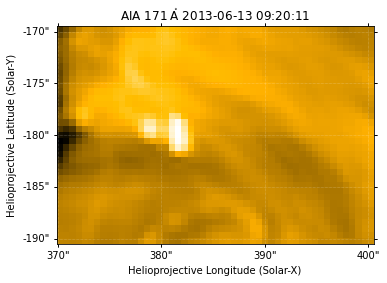

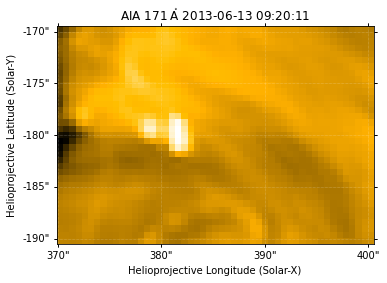

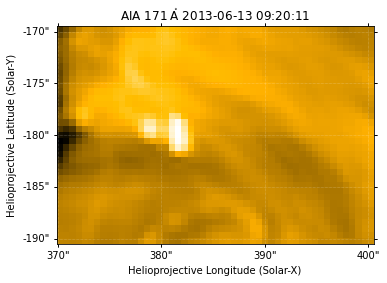

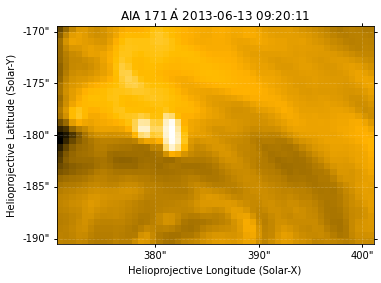

In [351]:
maps_94_roi[0].plot()
plt.show()

maps_171_roi[0].plot()
plt.show()

maps_304_roi[0].plot()
plt.show()

maps_1700_roi[0].plot()
plt.show()


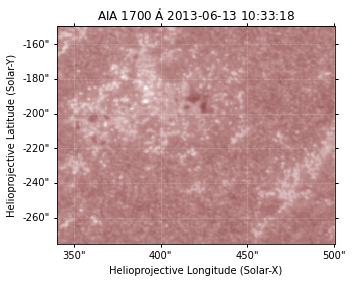

In [345]:
maps_1700 = Fits_to_maps('AIA_1700_prep_rot_done')
maps_1700[0].plot()

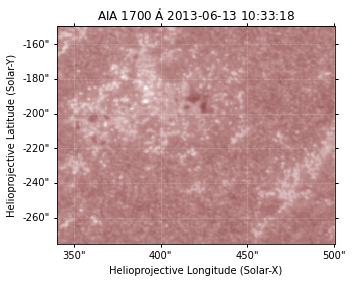

In [347]:
maps_1700[0].plot()

In [ ]:
intensity_1700 = intenisty_sum(maps_1700)
intensity_304 = intenisty_sum(maps_304)
intensity_171 = intenisty_sum(maps_171)
intensity_94 = intenisty_sum(maps_94)

In [231]:
def windowed_fourier(intensity_array):
   
    intensity_cal = []
    for i in intensity_array:
        intensity = (i-np.mean(intensity_array))/np.std(intensity_array)
        intensity_cal.append(intensity)
    
    # intenisty_cal = np.ma.masked_less(intensity_cal, 0)

    window = signal.windows.hann(len(intensity_cal))

    plt.figure(figsize = (15,15))
    intensity_window = window*intensity_cal

    fft_result = np.fft.fft(intensity_window)
    fft = (np.abs(fft_result)**2)/np.var(intensity_window)
    freqs = np.fft.fftfreq(len(intensity_window), 12)

    # plt.plot(1/(freqs),(fft))
    # plt.yscale('log')
    # plt.xscale('log')
    # plt.xlabel("Period (s)")
    # plt.ylabel("Magnitude")
    # plt.title("Intensity ")
    # plt.savefig(fname = '171PowerSpectrum.jpeg',format="jpeg", bbox_inches="tight")

    # plt.show()

    return freqs, fft

def quadratic(x,a,b):

    y=a*(x**2)+b
    
    return y


def e_func(x,a,b,c):

    
    y= a*2.7**(x*b)+c
    
    return y


print(len(intensity_1700))

183


183
183
 15407.812454895282,12277.20798062183,-134113350.5096186


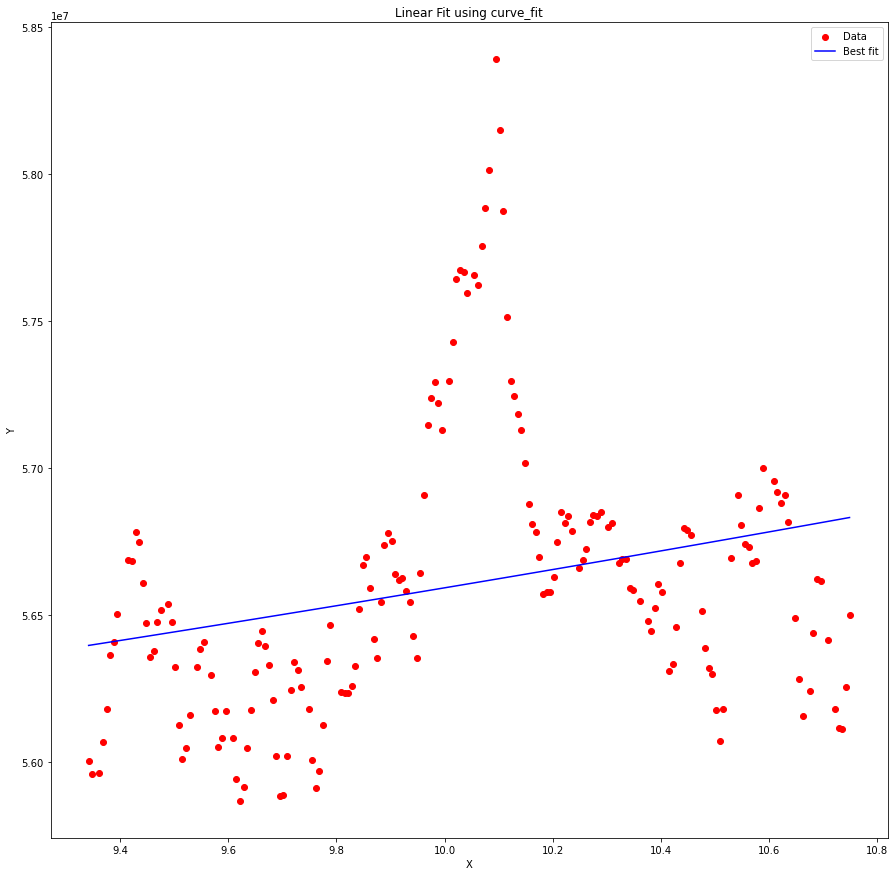

In [193]:
time_list_1700 = [dt.time() for dt in time_axis_1700]
# print(time_list_1700)
time_string_list_1700 = [t.strftime('%H:%M:%S') for t in time_list_1700]
# print(time_string_list_1700)
time_float_list_1700 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_list_1700
]
print(len(time_float_list_1700))
print(len(intensity_1700))


windowed_fourier(intensity_1700)


# Use curve_fit to fit the model to the data
params, covariance = curve_fit(quadratic, (time_float_list_1700), (intensity_1700),p0=[1, 1, 1],maxfev =10000000)

# Extract the optimal parameters
a_opt, b_opt, c_opt = params
print(f" {a_opt},{b_opt},{c_opt}")

# Generate the fitted line
x_fit = np.linspace(min(time_float_list_1700), max(time_float_list_1700), 100)
y_fit = quadratic(x_fit, a_opt, b_opt,c_opt)

# Plot the data and the fitted line
plt.scatter(time_float_list_1700, intensity_1700, label="Data", color="red")
plt.plot(x_fit, y_fit, label="Best fit", color="blue")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Linear Fit using curve_fit")
plt.show()

1698.0000000000002 24.085106382978726
 0.0012220574537038162,120.2892923734669,92.14384925097843


/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/1481487884.py:16: RuntimeWarning: divide by zero encountered in divide
  period = (1/freqs)


<Figure size 1080x1080 with 0 Axes>

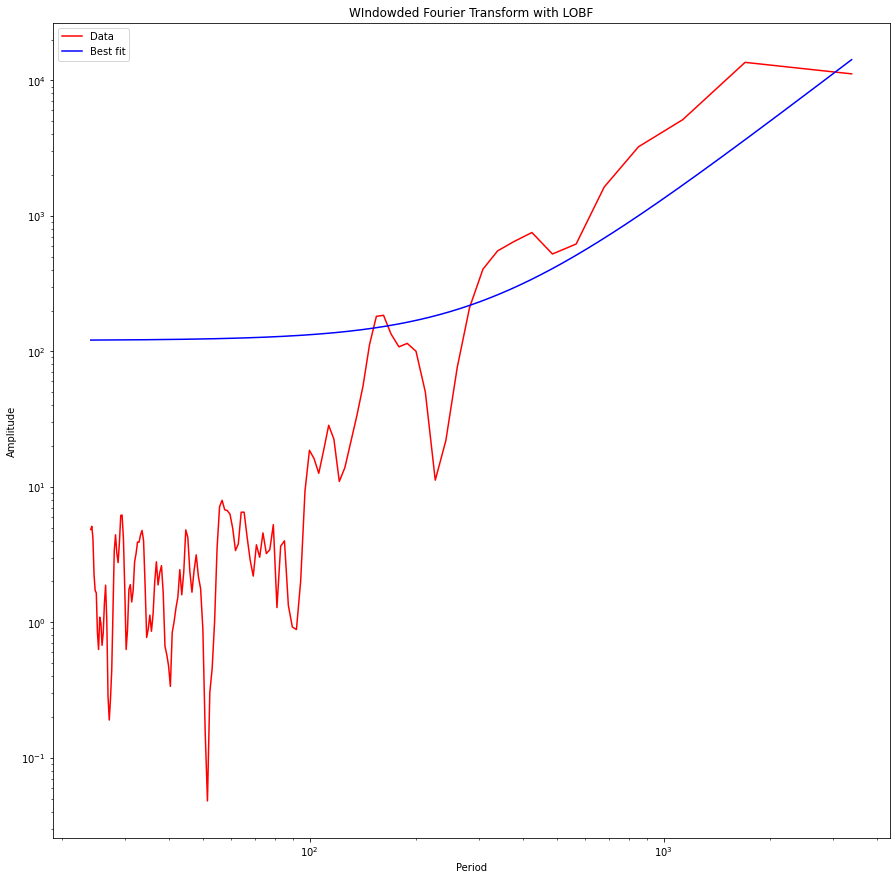

In [295]:
windowed_fourier(intensity_304)

time_list_304 = [dt.time() for dt in time_axis_304]
# print(time_list_1700)
time_string_list_304 = [t.strftime('%H:%M:%S') for t in time_list_304]
# print(time_string_list_1700)
time_float_list_304 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_list_304
]
# print(len(time_float_list_1700))
# print(len(intensity_1700))


freqs,fft = windowed_fourier(intensity_304)
# print(freqs,fft)
period = (1/freqs)
period = (period[1:142])
print(period[1],period[140])
# Use curve_fit to fit the model to the data
params, covariance = curve_fit(quadratic, period, fft[1:142],p0=[0.01, 1],maxfev =10000000)#[1:len(freqs)]
# print(len(freqs))
# Extract the optimal parameters
a_opt, b_opt= params

print(f" {a_opt},{b_opt},{c_opt}")

# Generate the fitted line
x_fit = np.arange(np.e**3.1815936570530696,np.e**8.130353547431238)
y_fit = quadratic(x_fit, a_opt, b_opt)
# print(np.log(1/freqs)[1])
# print(((1/freqs)))
# Plot the data and the fitted line
plt.plot(period, fft[1:142], label="Data", color="red")
plt.plot(x_fit, y_fit, label="Best fit", color="blue")
plt.xlabel("Period")
plt.ylabel("Amplitude")
plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0,100)
# plt.ylim(0,5)
plt.title("WIndowded Fourier Transform with LOBF")
plt.show()

# print(freqs)
# plt.plot(1/(freqs),(fft))
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel("Period (s)")
# plt.ylabel("Magnitude")
# plt.title("Intensity ")
# plt.savefig(fname = '171PowerSpectrum.jpeg',format="jpeg", bbox_inches="tight")

# plt.show()

# break point

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/1719161089.py:41: RuntimeWarning: overflow encountered in power
  y= a*2.7**(x*b)+c
/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/351306161.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(e_func, period, (fft)[1:142],p0=[1, 1,1],maxfev =10000000)#[1:len(freqs)]


 1.0,1.0,1.0
[]
[]


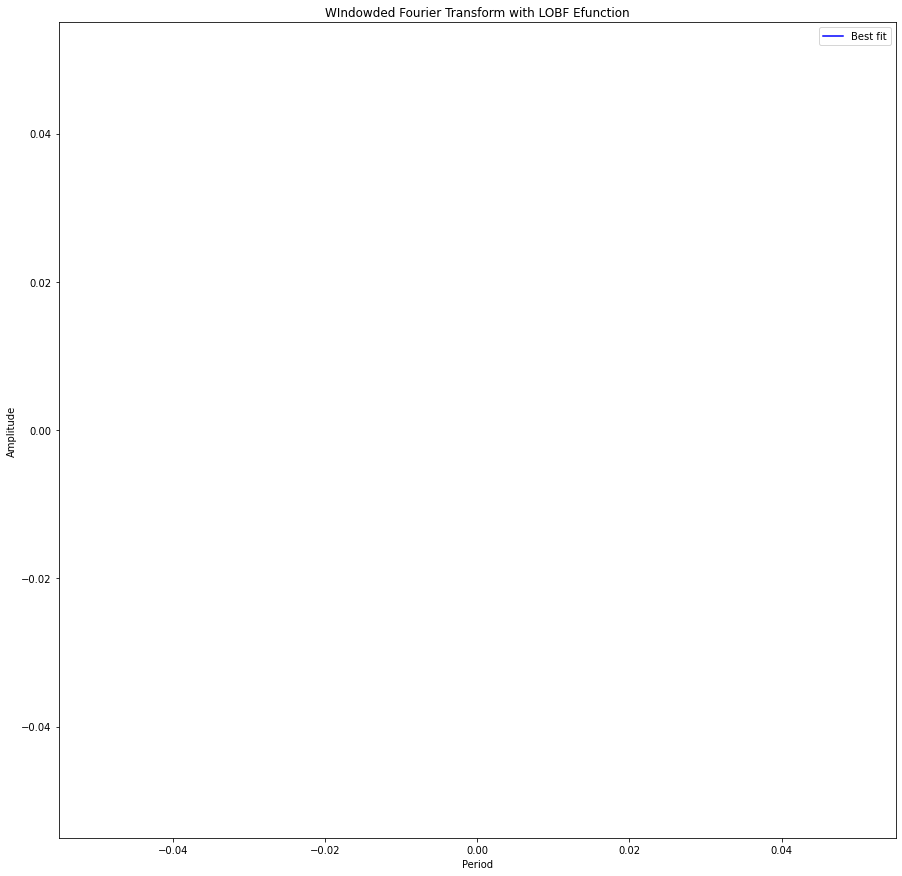

In [302]:
time_list_304 = [dt.time() for dt in time_axis_304]
# print(time_list_1700)
time_string_list_304 = [t.strftime('%H:%M:%S') for t in time_list_304]
# print(time_string_list_1700)
time_float_list_304 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_list_304
]
# print(len(time_float_list_1700))
# print(len(intensity_1700))
len(freqs)

freqs,fft = windowed_fourier(intensity_304)
# print(freqs,fft)

# Use curve_fit to fit the model to the data
params, covariance = curve_fit(e_func, period, (fft)[1:142],p0=[1, 1,1],maxfev =10000000)#[1:len(freqs)]
# print(len(freqs))
# Extract the optimal parameters
a_opt, b_opt, c_opt= params

print(f" {a_opt},{b_opt},{c_opt}")

x_fit = np.arange(period[0],period[140],1000)
y_fit = e_func(x_fit, a_opt, b_opt,c_opt)
print(x_fit)
print(y_fit)
# print(np.log(1/freqs)[1])
# print((np.log(1/freqs)))


# plt.plot(period, fft[1:142], label="Data", color="red")
plt.plot(x_fit, y_fit, label="Best fit", color="blue")
plt.xlabel("Period")
plt.ylabel("Amplitude")
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0,100)
# plt.ylim(0,5)
plt.title("WIndowded Fourier Transform with LOBF Efunction")
plt.show()


[ 0.          0.00020781  0.00041563  0.00062344  0.00083126  0.00103907
  0.00124688  0.0014547   0.00166251  0.00187032  0.00207814  0.00228595
  0.00249377  0.00270158  0.00290939  0.00311721  0.00332502  0.00353283
  0.00374065  0.00394846  0.00415628  0.00436409  0.0045719   0.00477972
  0.00498753  0.00519534  0.00540316  0.00561097  0.00581879  0.0060266
  0.00623441  0.00644223  0.00665004  0.00685786  0.00706567  0.00727348
  0.0074813   0.00768911  0.00789692  0.00810474  0.00831255  0.00852037
  0.00872818  0.00893599  0.00914381  0.00935162  0.00955943  0.00976725
  0.00997506  0.01018288  0.01039069  0.0105985   0.01080632  0.01101413
  0.01122195  0.01142976  0.01163757  0.01184539  0.0120532   0.01226101
  0.01246883  0.01267664  0.01288446  0.01309227  0.01330008  0.0135079
  0.01371571  0.01392352  0.01413134  0.01433915  0.01454697  0.01475478
  0.01496259  0.01517041  0.01537822  0.01558603  0.01579385  0.01600166
  0.01620948  0.01641729  0.0166251   0.01683292  0.0

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/1712041991.py:13: RuntimeWarning: divide by zero encountered in divide
  params, covariance = curve_fit(quadratic, (1/freqs)[1:len(freqs)], (fft)[1:len(freqs)],p0=[1, 1],maxfev =10000000)#[1:len(freqs)]
/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/1712041991.py:19: RuntimeWarning: divide by zero encountered in divide
  print(1/freqs)
/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/1712041991.py:25: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freqs, fft, label="Data", color="red")


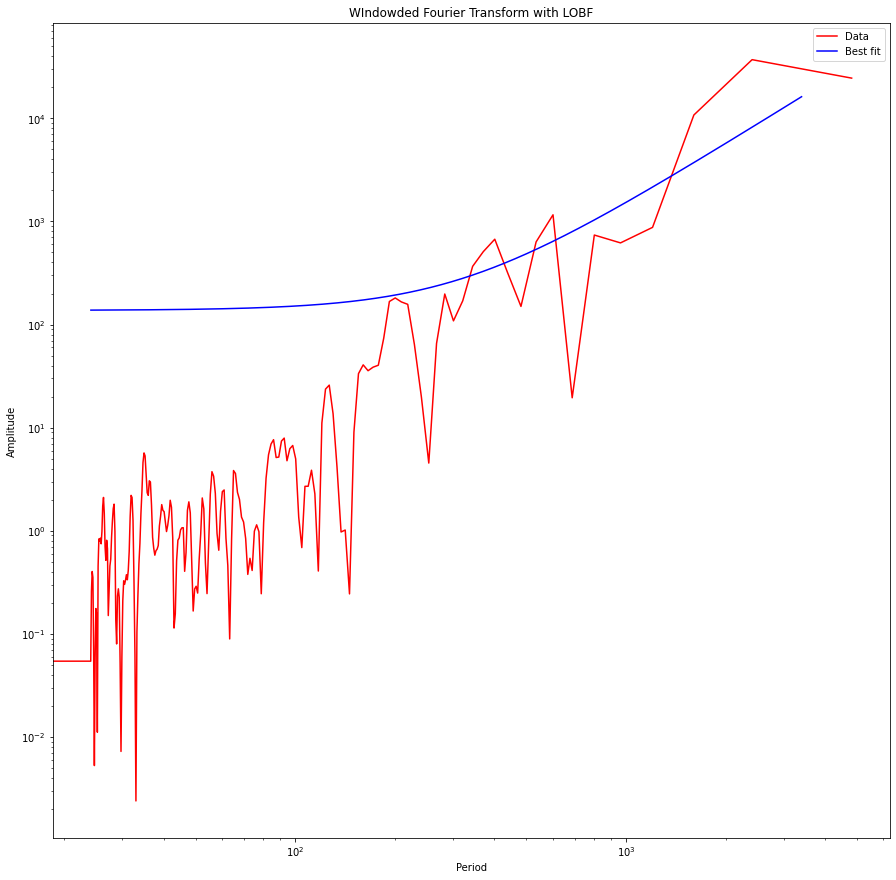

In [301]:



time_list_171 = [dt.time() for dt in time_axis_171]

time_string_list_171 = [t.strftime('%H:%M:%S') for t in time_list_171]

time_float_list_171 = [
    t.hour + t.minute / 60 + t.second / 3600 + t.microsecond / 3_600_000_000 for t in time_list_171
]


freqs,fft = windowed_fourier(intensity_171)
print(freqs,fft)

params, covariance = curve_fit(quadratic, (1/freqs)[1:len(freqs)], (fft)[1:len(freqs)],p0=[1, 1],maxfev =10000000)#[1:len(freqs)]

a_opt, b_opt= params

print(f" {a_opt},{b_opt},{c_opt}")

print(1/freqs)
x_fit = np.arange(np.e**3.1815936570530696,np.e**8.130353547431238)
y_fit = quadratic(x_fit, a_opt, b_opt)
# print(np.log(1/freqs)[1])
# print((np.log(1/freqs)))

plt.plot(1/freqs, fft, label="Data", color="red")
plt.plot(x_fit, y_fit, label="Best fit", color="blue")
plt.xlabel("Period")
plt.ylabel("Amplitude")
plt.legend()
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0,100)
# plt.ylim(0,5)
plt.title("WIndowded Fourier Transform with LOBF")
plt.show()


/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/2216994273.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/(freqs),(fft))


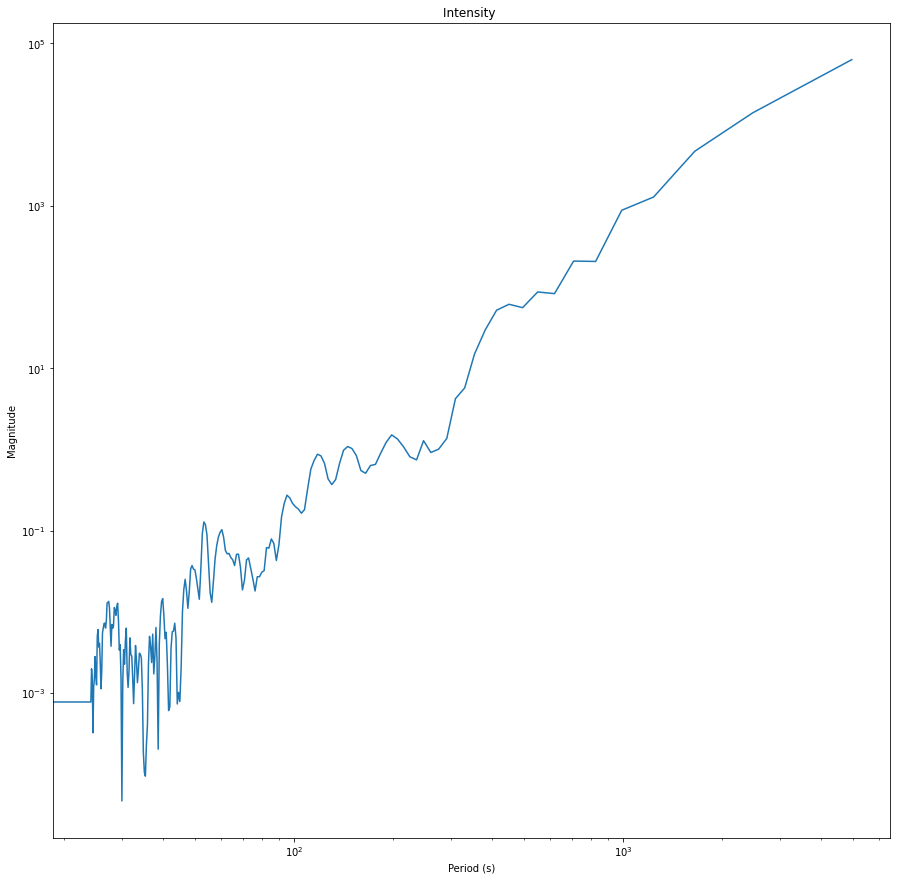

In [71]:
windowed_fourier(intensity_94)

/var/folders/96/6cy2m0cs6f58g_nf35j6n89c0000gn/T/ipykernel_11655/534022708.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/(freqs_1700),(fft_1700))


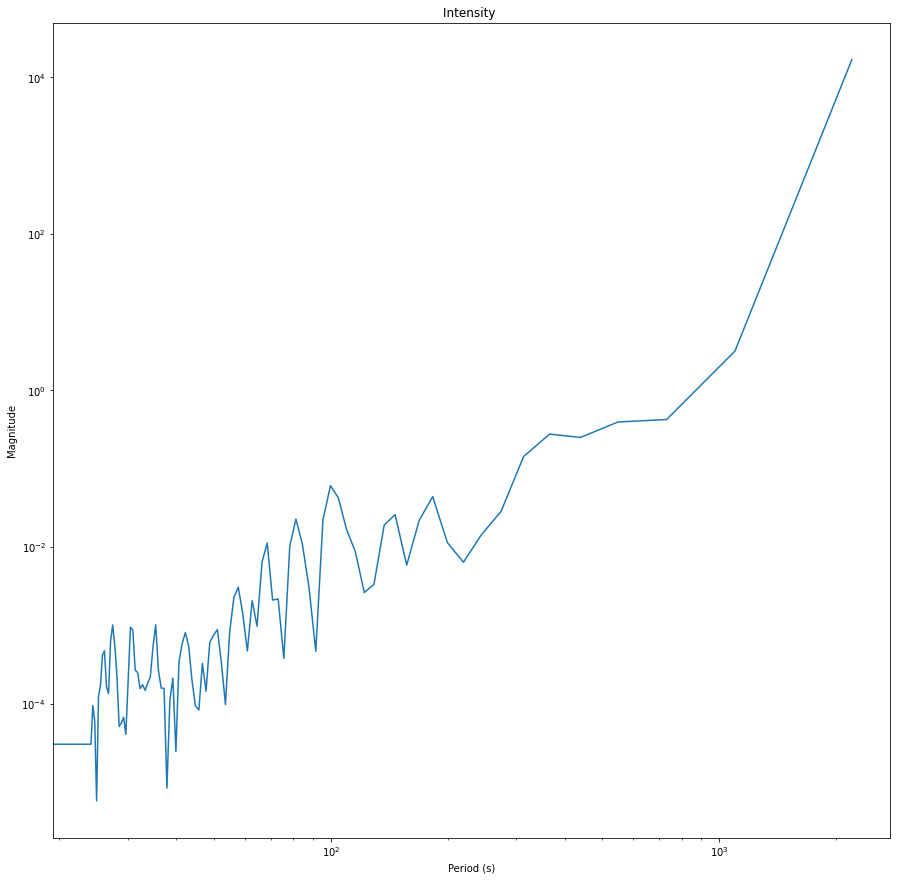

In [ ]:
freqs_1700, fft_1700 = windowed_fourier(intensity_1700)


plt.plot(1/(freqs_1700),(fft_1700))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Period (s)")
plt.ylabel("Magnitude")
plt.title("Windowed Fourier Transform - 1700Å ")
plt.savefig(fname = '171PowerSpectrum.jpeg',format="jpeg", bbox_inches="tight")

plt.show()